###  importing relevant libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
from numpy import array
from random import random
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB#57
from sklearn.naive_bayes import GaussianNB#52
from sklearn.naive_bayes import MultinomialNB#56
from sklearn.naive_bayes import CategoricalNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import csv
import math
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import time



### Discovering Labels

In [3]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [4]:
def folder(f_name): #this function creates a folder.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("Tthe folder could not be created!")

In [5]:
def find_the_way(path,file_format):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                files_add.append(os.path.join(r, file))  
    return files_add

### Hyperparameters of machine learning algorithm.

In [6]:
ml_list={"NB":CategoricalNB(alpha=1e-09),
"DT" :DecisionTreeClassifier(criterion='gini', max_depth=26.0,
                       max_features=26,min_samples_split= 6),  
"RF":RandomForestClassifier(bootstrap= True, criterion= "gini", max_depth= 18.0, max_features= 8, min_samples_split= 9, n_estimators= 96),
"KNN":KNeighborsClassifier(algorithm= 'brute', leaf_size= 41, n_neighbors= 48, weights= 'distance'),
"GB":GradientBoostingClassifier(learning_rate= 0.1838641631843394, max_depth= 6, n_estimators= 535, subsample= 0.7134682210818548)}

# Aggregation Algorithm normal

In [7]:
altime=0
#def most_frequent(List): 
#    return max(set(List), key = List.count) 


 
def most_frequent(List):
    occurence_count = Counter(List)
    occurence_count={k: v for k, v in sorted(occurence_count.items(), key=lambda item: item[1],reverse=True)}
    big=list(occurence_count.values())
    big=big.count(big[0])
    return list(occurence_count.keys())[np.random.randint(big)]


def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
def create_exception(df): 
    exception_list=[]
    dominant_mac=[]
    for i in df['aggregated'].unique():
        k=df[df['aggregated']==i]
        for ii in ['MAC']:
            hist = {}
            for x in k[ii].values:
                hist[x] = hist.get(x, 0) + 1
            hist=dict(sorted(hist.items(), key=lambda item: item[1],reverse=True))
            temp=next(iter(hist))
            if temp not in dominant_mac:
                dominant_mac.append(temp)
            else:
                exception_list.append(temp)
    return exception_list




def merged(m_test,predict,step,mixed):
    second=time.time()
    mac_test=[]
    for q in m_test.index:
        mac_test.append(m_test[q])

    d_list=sorted(list(m_test.unique()))
    devices={}
    for q in d_list:
        devices[q]=[]    


    new_y=[0]*len(m_test)

    for q,qq in enumerate (mac_test):
        devices[qq].append(q)
    for q in devices:
        a = [devices[q][j:j + step] for j in range(0, len(devices[q]), step)]  
        for qq in a:
            step_list=[]
            for qqq in qq:
                step_list.append(predict[qqq])
            add=most_frequent(list(step_list))
            for qqq in qq:
                new_y[qqq]=add
    results=pd.DataFrame(m_test)
    results["aggregated"]=new_y
    results["normal"]=predict
    
    #MIXED METHOD
    if mixed:
        exception=create_exception(results)
        for q in exception:
            results.loc[results.MAC == q, 'aggregated'] = results['normal']

    return results["aggregated"].values,time.time()-second














## Calculation of evaluations

In [8]:
def score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii):
    precision=[]
    recall=[]
    f1=[]
    accuracy=[]
    total_time=[]
    kappa=[]
    accuracy_b=[]
    
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")        
    report = classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    precision.append(float(pr))
    recall.append(float(rc))
    f1.append(float(f_1))
    accuracy_b.append(balanced_accuracy_score( y_test,predict))
    accuracy.append(accuracy_score(y_test, predict))

    kappa.append(round(float(sklearn.metrics.cohen_kappa_score(y_test, predict, 
    labels=None, weights=None, sample_weight=None)),15))
    print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-8s %-5s %-8s %-8s%-8s%-8s' % (dname,i,cv,ii[0:6],str(round(np.mean(accuracy),2)),str(round(np.mean(accuracy_b),2)),
        str(round(np.mean(precision),2)), str(round(np.mean(recall),2)),str(round(np.mean(f1),4)), 
        str(round(np.mean(kappa),2)),str(round(np.mean(train_time),2)),str(round(np.mean(test_time),2)),str(round(np.mean(test_time)+np.mean(train_time),2)),str(round(np.mean(altime),2))))
    lines=(str(dname)+","+str(i)+","+str(cv)+","+str(ii)+","+str(round(np.mean(accuracy),15))+","+str(round(np.mean(accuracy_b),15))+","+str(round(np.mean(precision),15))+","+ str(round(np.mean(recall),15))+","+str(round(np.mean(f1),15))+","+str(round(np.mean(kappa),15))+","+str(round(np.mean(train_time),15))+","+str(round(np.mean(test_time),15))+","+str(altime)+"\n")
    return lines,class_based_results

In [9]:
def ML(loop1,loop2,output_csv,cols,step,mixed,dname):

    ths = open(output_csv, "w")
    ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,Al-Time\n")
    

    from sklearn.metrics import balanced_accuracy_score
    from sklearn.preprocessing import Normalizer
    
    for ii in ml_list:
        print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-8s %-5s %-8s %-8s%-8s%-8s'%
               ("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        if ii in ["GB","SVM"]: #for slow algorithms.
            repetition=10 
        else:
            repetition=100
        for i in range(repetition):



            #TRAIN
            df = pd.read_csv(loop1,usecols=cols)
            m_train=df["MAC"]
            del df["MAC"]
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  

            #TEST
            df = pd.read_csv(loop2,usecols=cols)
            df = shuffle(df, random_state=42)
            m_test=df["MAC"]
            del df["MAC"]
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes




            results_y=[]
            cv+=1
            results_y.append(y_test)


     
   

            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time=(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time=(float((time.time()-second)) )
            if step==1:
                altime=0
                lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            else:
                predict,altime=merged(m_test,predict,step,mixed)
                lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            ths.write (lines)


            df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)
            
        class_based_results=class_based_results/repetition
        print(class_based_results)
        class_based_results.to_csv("class_based_results.csv")
        if True:
            cm=cm//repetition
            graph_name=output_csv+ii+"_confusion matrix.pdf"   
            plt.figure(figsize = (40,28))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


            
            
            
            
            
            
            


    ths.close()  

# Machine learning applications 

#  IoTSentinel

In [25]:
feature= ['ARP', 'LLC', 'EAPOL', 'IP', 'ICMP', 'ICMP6', 'TCP', 'UDP', 'HTTP',
       'HTTPS', 'DHCP', 'BOOTP', 'SSDP', 'DNS', 'MDNS', 'NTP', 'IP_padding',
       'IP_add_count', 'IP_ralert', 'Portcl_src', 'Portcl_dst', 'Pck_size',
       'Pck_rawdata', 'MAC', 'Label']

In [26]:
ml_list={"DT" :DecisionTreeClassifier(criterion='entropy', max_depth=31.0,
                       max_features=14,min_samples_split= 6)}
dataset="./sentinel/"
folder(dataset)

###  IoT Sentinel Normal

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
sentinel_1      0   1   DT      0.7   0.59  0.64  0.59  0.6014   0.67  0.08     0.01    0.08    0.0     
sentinel_1      1   2   DT      0.7   0.59  0.64  0.59  0.6014   0.67  0.08     0.01    0.09    0.0     
sentinel_1      2   3   DT      0.7   0.59  0.65  0.59  0.6019   0.67  0.08     0.01    0.09    0.0     
sentinel_1      3   4   DT      0.7   0.59  0.65  0.59  0.6025   0.67  0.08     0.01    0.08    0.0     
sentinel_1      4   5   DT      0.7   0.59  0.65  0.59  0.6053   0.67  0.08     0.01    0.09    0.0     
sentinel_1      5   6   DT      0.7   0.59  0.65  0.59  0.6005   0.67  0.08     0.01    0.08    0.0     
sentinel_1      6   7   DT      0.7   0.59  0.65  0.59  0.6009   0.67  0.07     0.01    0.08    0.0     
sentinel_1      7   8   DT      0.7   0.59  0.65  0.59  0.6017   0.67  0.08     0.01    0.09    0.0     
sentinel_1      8   9   DT      0.7   0.59  0.65  0.59 

sentinel_1      78  79  DT      0.7   0.59  0.65  0.59  0.604    0.67  0.06     0.0     0.07    0.0     
sentinel_1      79  80  DT      0.7   0.59  0.64  0.59  0.6001   0.67  0.07     0.01    0.09    0.0     
sentinel_1      80  81  DT      0.7   0.59  0.65  0.59  0.6031   0.67  0.08     0.01    0.09    0.0     
sentinel_1      81  82  DT      0.7   0.59  0.65  0.59  0.6053   0.67  0.08     0.01    0.09    0.0     
sentinel_1      82  83  DT      0.7   0.59  0.65  0.59  0.6034   0.67  0.08     0.01    0.08    0.0     
sentinel_1      83  84  DT      0.7   0.59  0.65  0.59  0.6048   0.67  0.08     0.0     0.08    0.0     
sentinel_1      84  85  DT      0.7   0.59  0.65  0.59  0.6016   0.67  0.08     0.01    0.08    0.0     
sentinel_1      85  86  DT      0.7   0.59  0.65  0.59  0.6019   0.67  0.07     0.01    0.07    0.0     
sentinel_1      86  87  DT      0.7   0.59  0.64  0.59  0.6009   0.67  0.08     0.01    0.09    0.0     
sentinel_1      87  88  DT      0.7   0.59  0.65  0.59 

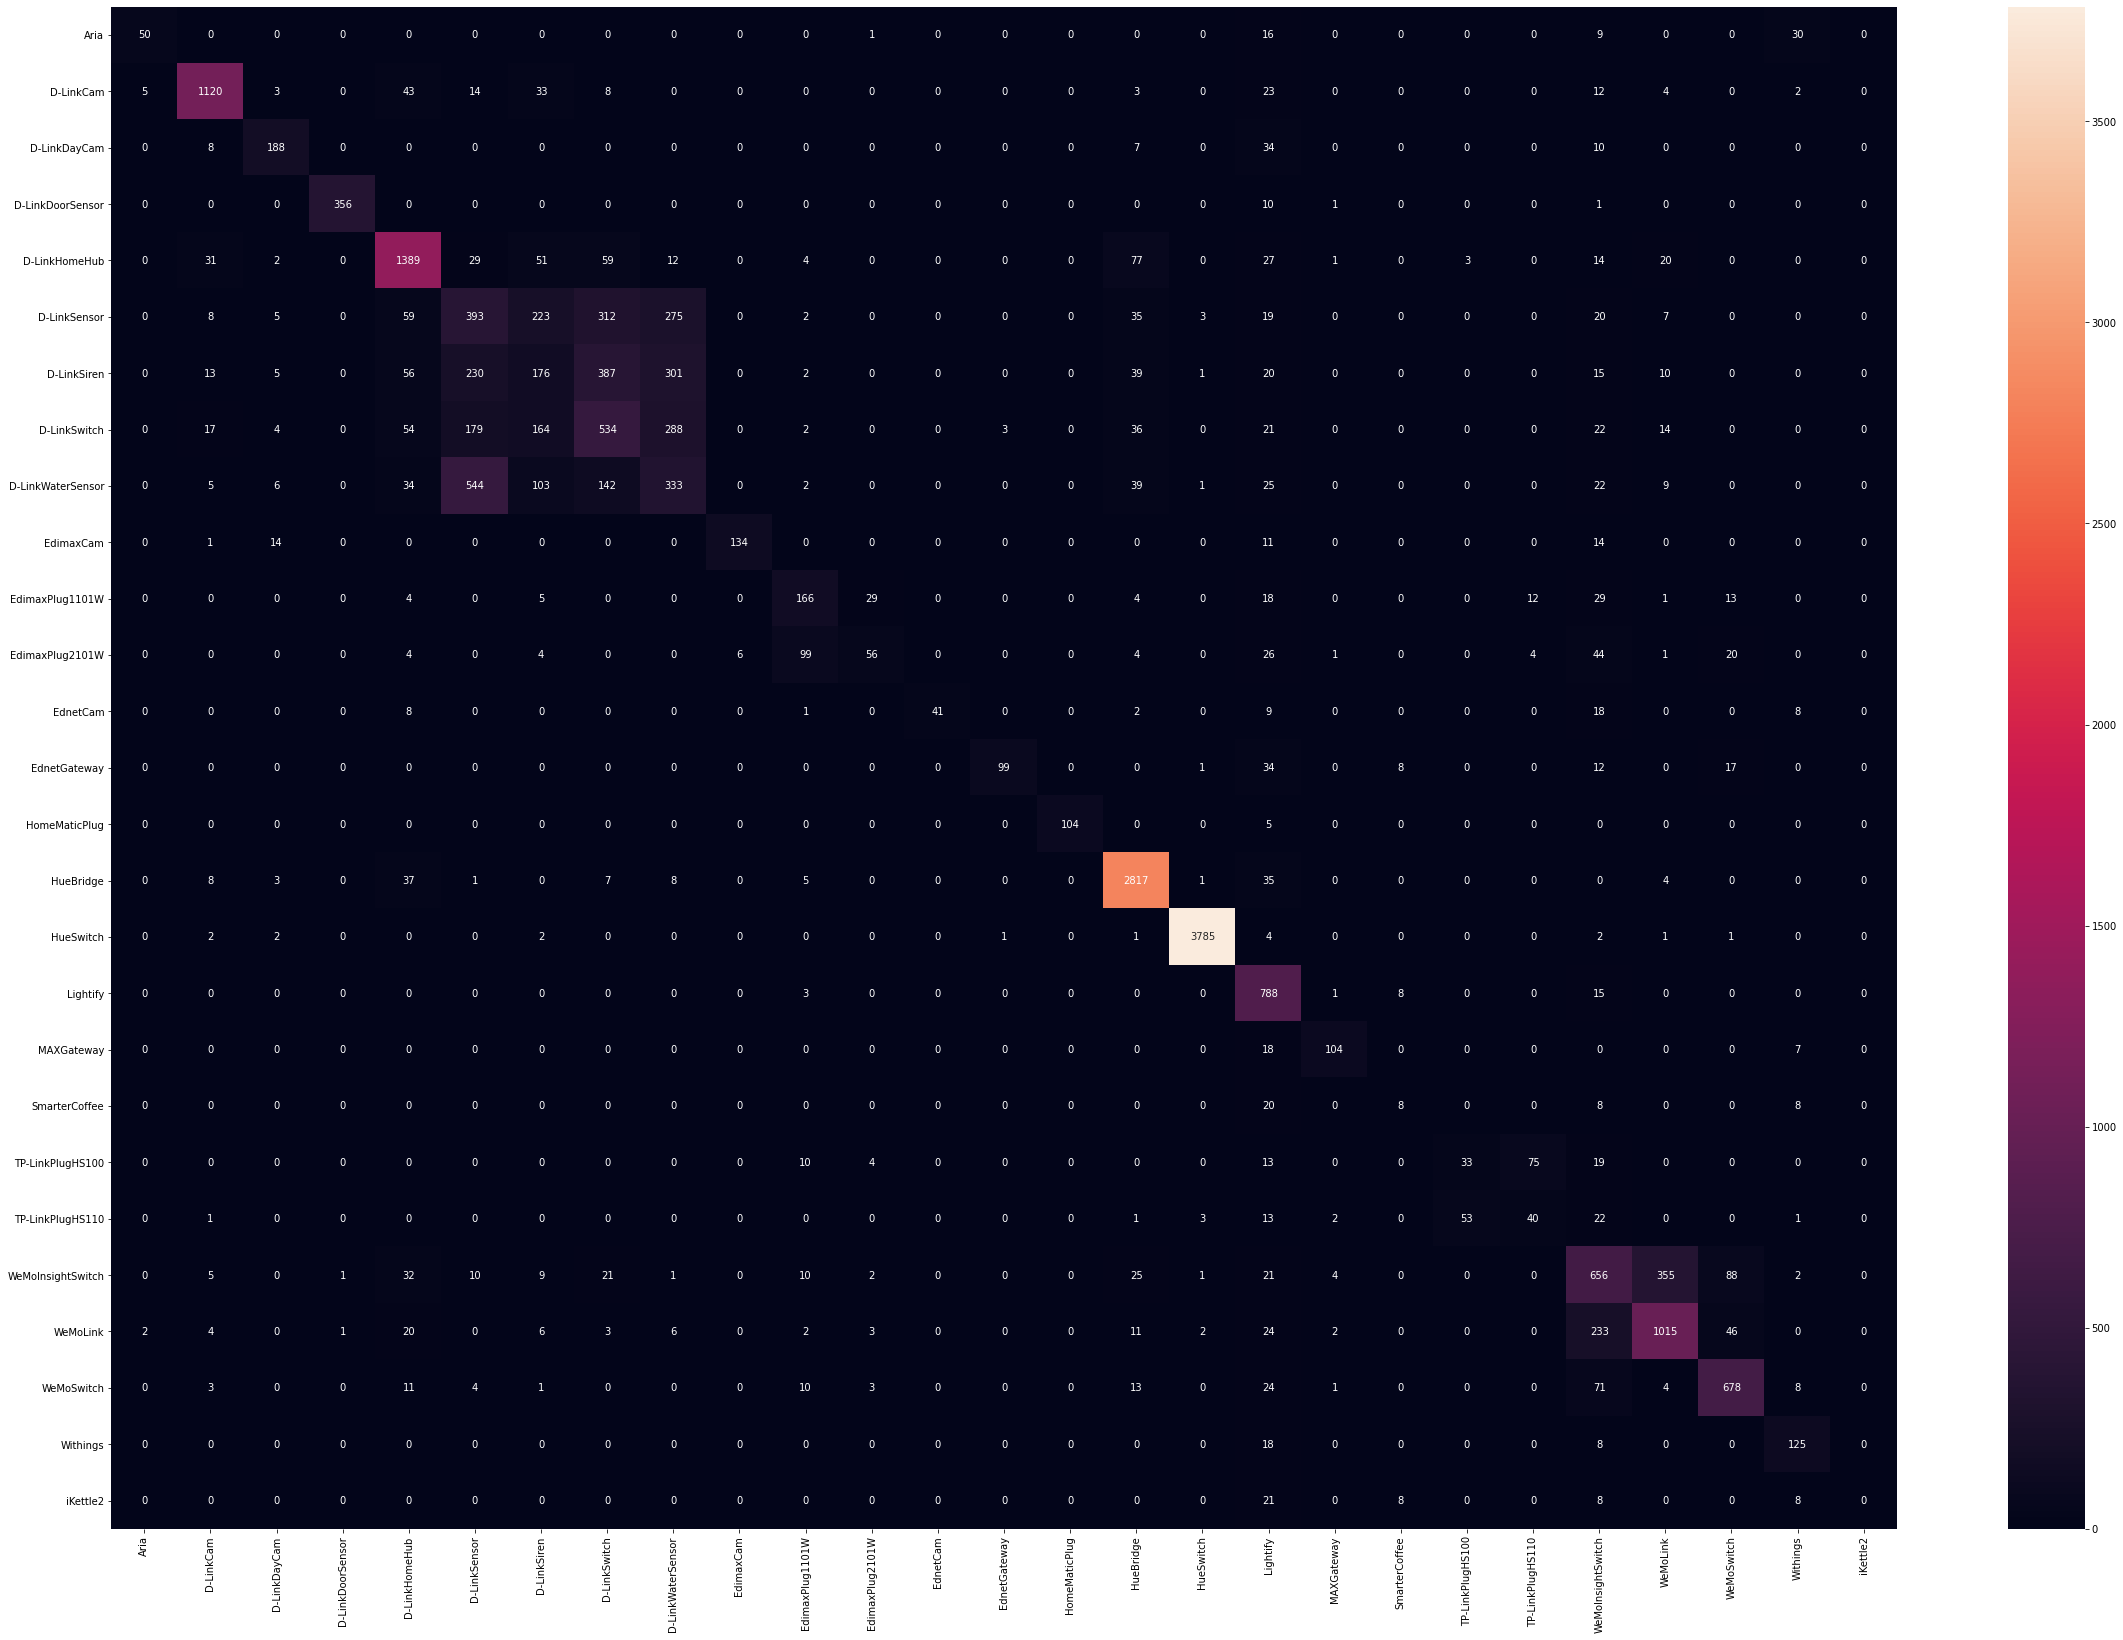

In [27]:

test='Aalto_IoTSentinel_Test.csv'
train='Aalto_IoTSentinel_Train.csv'




dataset="./sentinel/"
folder(dataset)

mixed=False
step=1
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


###  IoTSentinel Aagregeted

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
sentinel_13     0   1   DT      0.67  0.64  0.71  0.64  0.635    0.64  0.1      0.01    0.11    0.21    
sentinel_13     1   2   DT      0.67  0.65  0.7   0.65  0.6414   0.64  0.1      0.01    0.11    0.18    
sentinel_13     2   3   DT      0.67  0.64  0.7   0.64  0.6356   0.64  0.07     0.01    0.08    0.15    
sentinel_13     3   4   DT      0.67  0.65  0.7   0.65  0.6415   0.64  0.1      0.01    0.11    0.14    
sentinel_13     4   5   DT      0.67  0.65  0.71  0.65  0.6429   0.64  0.09     0.01    0.1     0.16    
sentinel_13     5   6   DT      0.67  0.65  0.71  0.65  0.6397   0.64  0.07     0.0     0.07    0.13    
sentinel_13     6   7   DT      0.67  0.65  0.71  0.65  0.6407   0.64  0.09     0.01    0.09    0.14    
sentinel_13     7   8   DT      0.67  0.65  0.71  0.65  0.6426   0.64  0.09     0.01    0.1     0.14    
sentinel_13     8   9   DT      0.67  0.65  0.71  0.65 

sentinel_13     78  79  DT      0.67  0.65  0.71  0.65  0.639    0.64  0.07     0.0     0.07    0.16    
sentinel_13     79  80  DT      0.68  0.65  0.71  0.65  0.6424   0.64  0.06     0.01    0.07    0.13    
sentinel_13     80  81  DT      0.67  0.65  0.7   0.65  0.6392   0.64  0.07     0.0     0.08    0.11    
sentinel_13     81  82  DT      0.67  0.64  0.7   0.64  0.6314   0.64  0.07     0.02    0.09    0.13    
sentinel_13     82  83  DT      0.67  0.66  0.71  0.66  0.6442   0.64  0.07     0.01    0.08    0.11    
sentinel_13     83  84  DT      0.67  0.65  0.71  0.65  0.6422   0.64  0.07     0.0     0.07    0.12    
sentinel_13     84  85  DT      0.67  0.65  0.7   0.65  0.6365   0.64  0.06     0.02    0.08    0.11    
sentinel_13     85  86  DT      0.67  0.64  0.7   0.64  0.6313   0.64  0.07     0.0     0.07    0.13    
sentinel_13     86  87  DT      0.67  0.65  0.7   0.65  0.6454   0.64  0.07     0.01    0.08    0.12    
sentinel_13     87  88  DT      0.67  0.64  0.7   0.64 

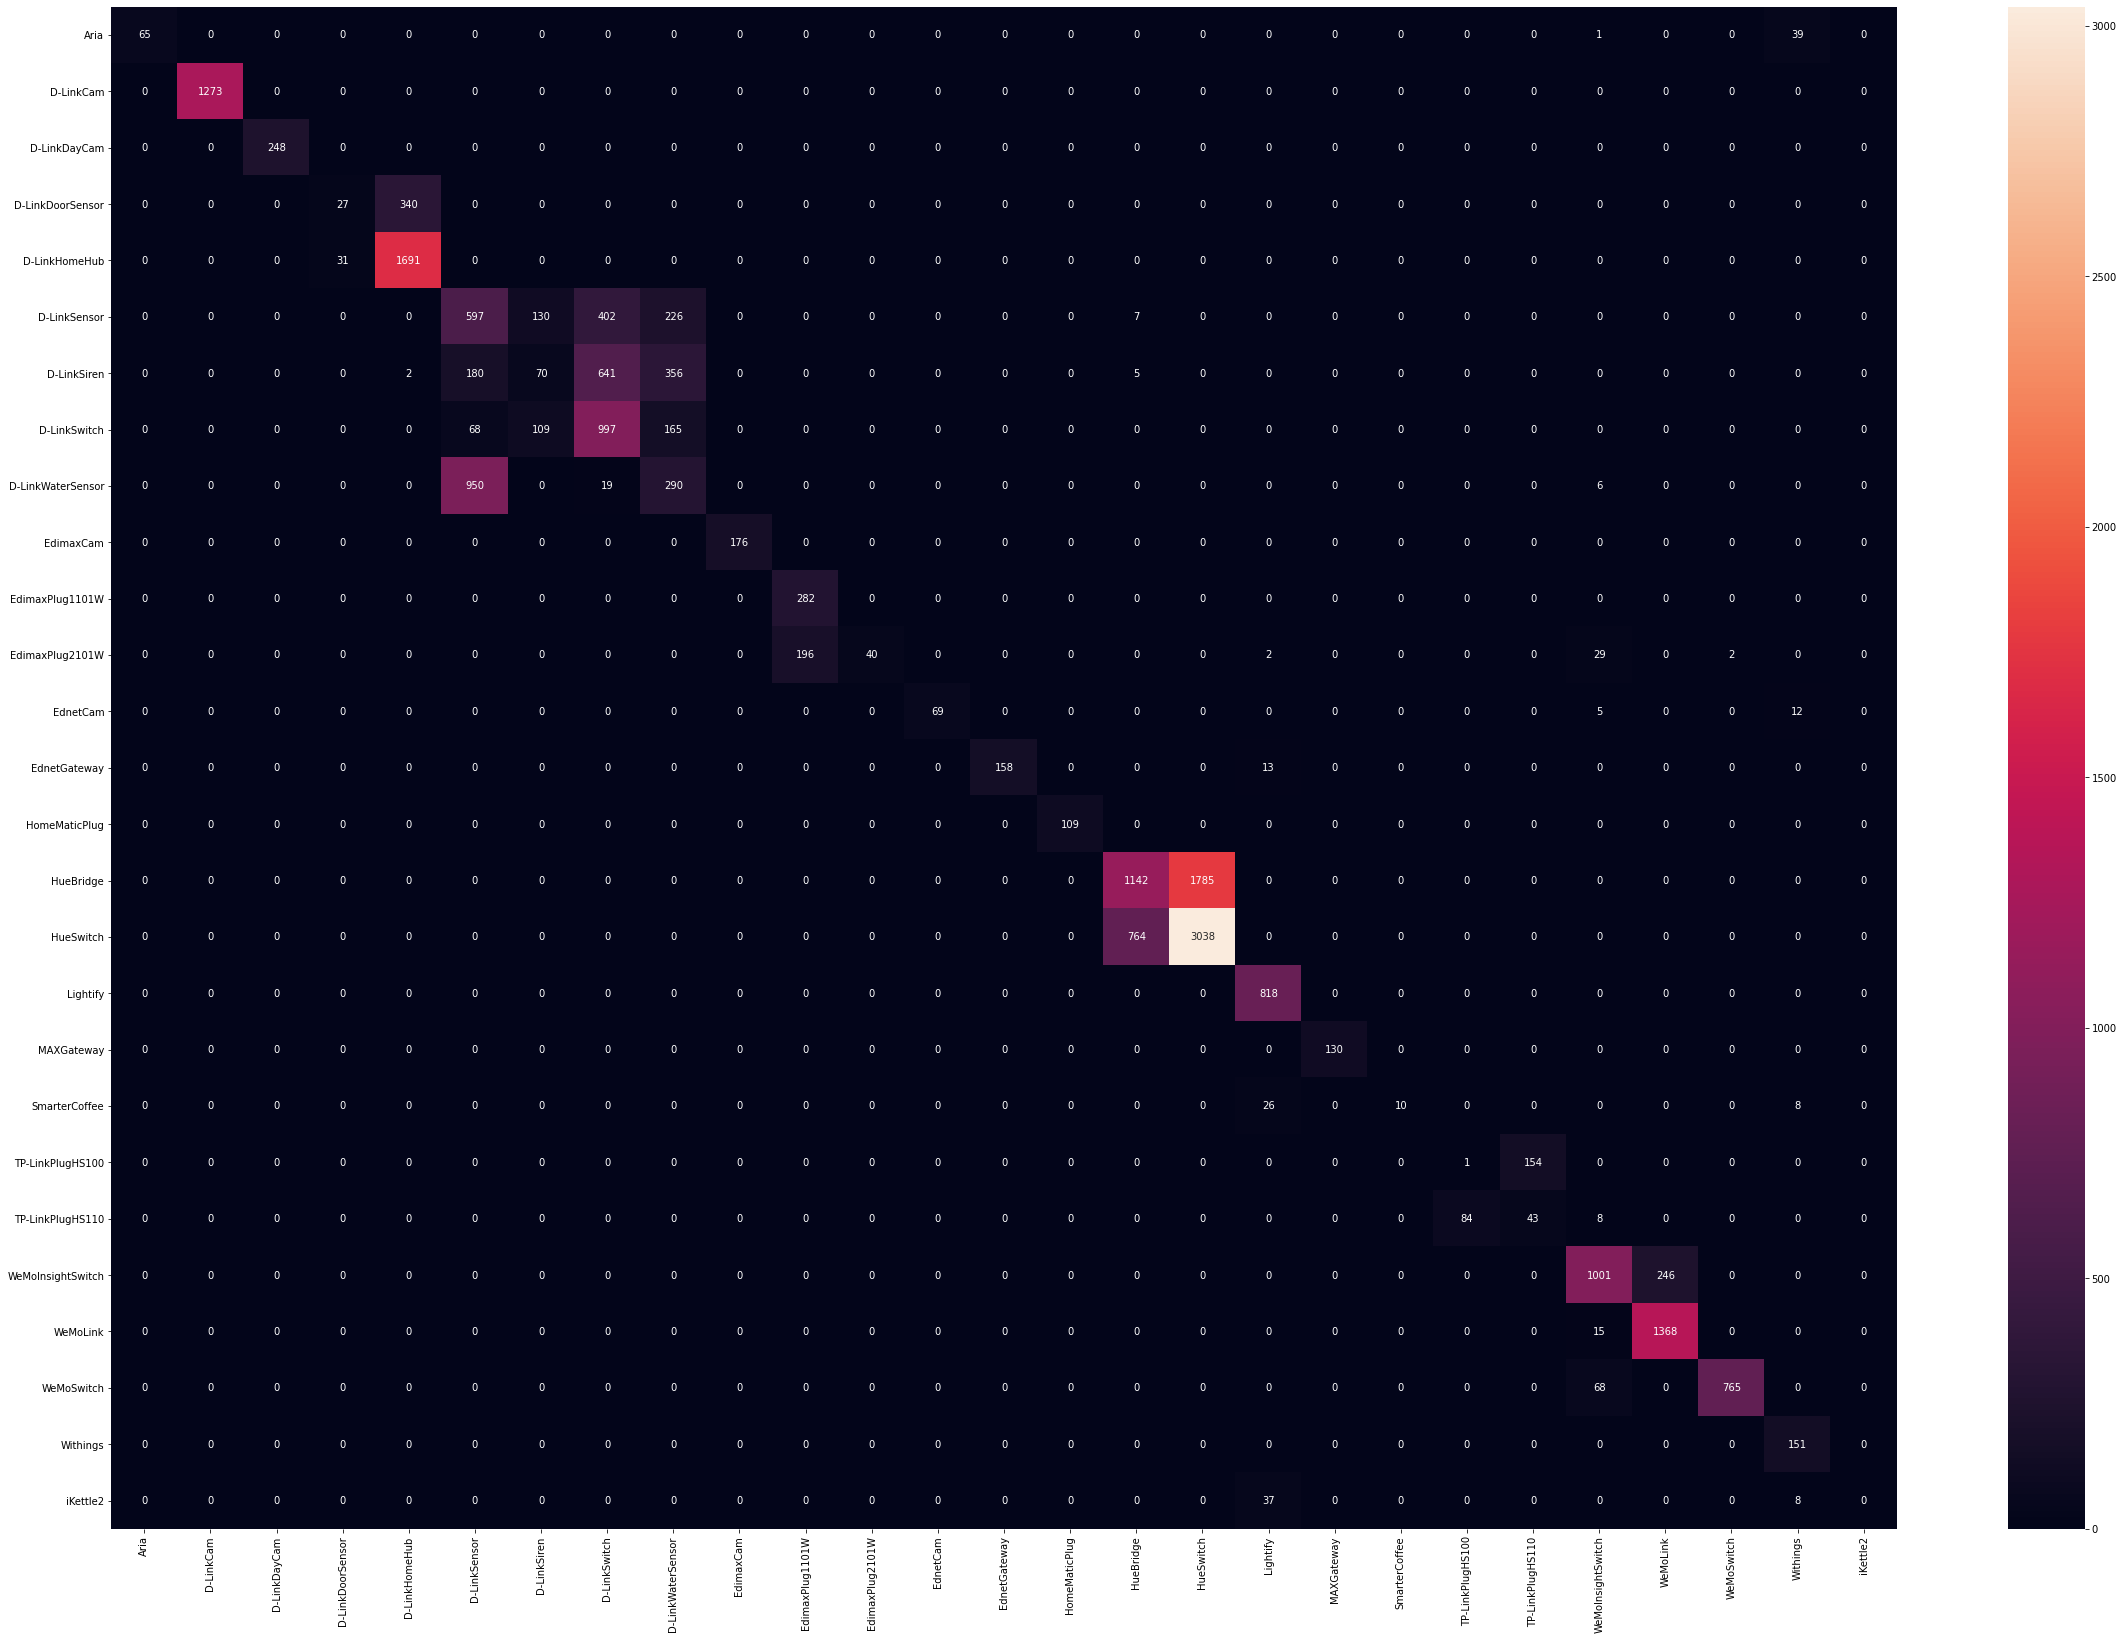

In [28]:

test='Aalto_IoTSentinel_Test.csv'
train='Aalto_IoTSentinel_Train.csv'


dataset="./sentinel/"
folder(dataset)

mixed=False
step=13
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


###  IoTSentinel Mixed

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
sentinel_13     0   1   DT      0.76  0.69  0.73  0.69  0.6803   0.74  0.08     0.0     0.08    0.17    
sentinel_13     1   2   DT      0.78  0.7   0.75  0.7   0.6899   0.76  0.06     0.02    0.08    0.16    
sentinel_13     2   3   DT      0.76  0.69  0.74  0.69  0.6848   0.74  0.08     0.0     0.08    0.2     
sentinel_13     3   4   DT      0.76  0.68  0.73  0.68  0.6782   0.74  0.08     0.01    0.09    0.16    
sentinel_13     4   5   DT      0.78  0.71  0.75  0.71  0.6964   0.76  0.07     0.0     0.07    0.17    
sentinel_13     5   6   DT      0.79  0.71  0.75  0.71  0.6976   0.77  0.07     0.0     0.07    0.15    
sentinel_13     6   7   DT      0.79  0.71  0.75  0.71  0.7005   0.77  0.07     0.01    0.07    0.16    
sentinel_13     7   8   DT      0.76  0.69  0.73  0.69  0.6798   0.74  0.07     0.0     0.07    0.16    
sentinel_13     8   9   DT      0.76  0.69  0.74  0.69 

sentinel_13     78  79  DT      0.78  0.7   0.75  0.7   0.6895   0.76  0.08     0.01    0.08    0.19    
sentinel_13     79  80  DT      0.79  0.71  0.75  0.71  0.6991   0.77  0.08     0.01    0.08    0.19    
sentinel_13     80  81  DT      0.78  0.7   0.75  0.7   0.6922   0.76  0.07     0.01    0.08    0.15    
sentinel_13     81  82  DT      0.78  0.69  0.74  0.69  0.6864   0.76  0.08     0.01    0.08    0.18    
sentinel_13     82  83  DT      0.76  0.69  0.73  0.69  0.68     0.74  0.08     0.01    0.09    0.15    
sentinel_13     83  84  DT      0.78  0.7   0.74  0.7   0.6899   0.76  0.08     0.01    0.09    0.14    
sentinel_13     84  85  DT      0.79  0.71  0.75  0.71  0.6974   0.77  0.07     0.01    0.07    0.21    
sentinel_13     85  86  DT      0.78  0.7   0.74  0.7   0.6862   0.76  0.07     0.01    0.08    0.21    
sentinel_13     86  87  DT      0.78  0.7   0.74  0.7   0.6924   0.76  0.08     0.01    0.08    0.14    
sentinel_13     87  88  DT      0.76  0.68  0.73  0.68 

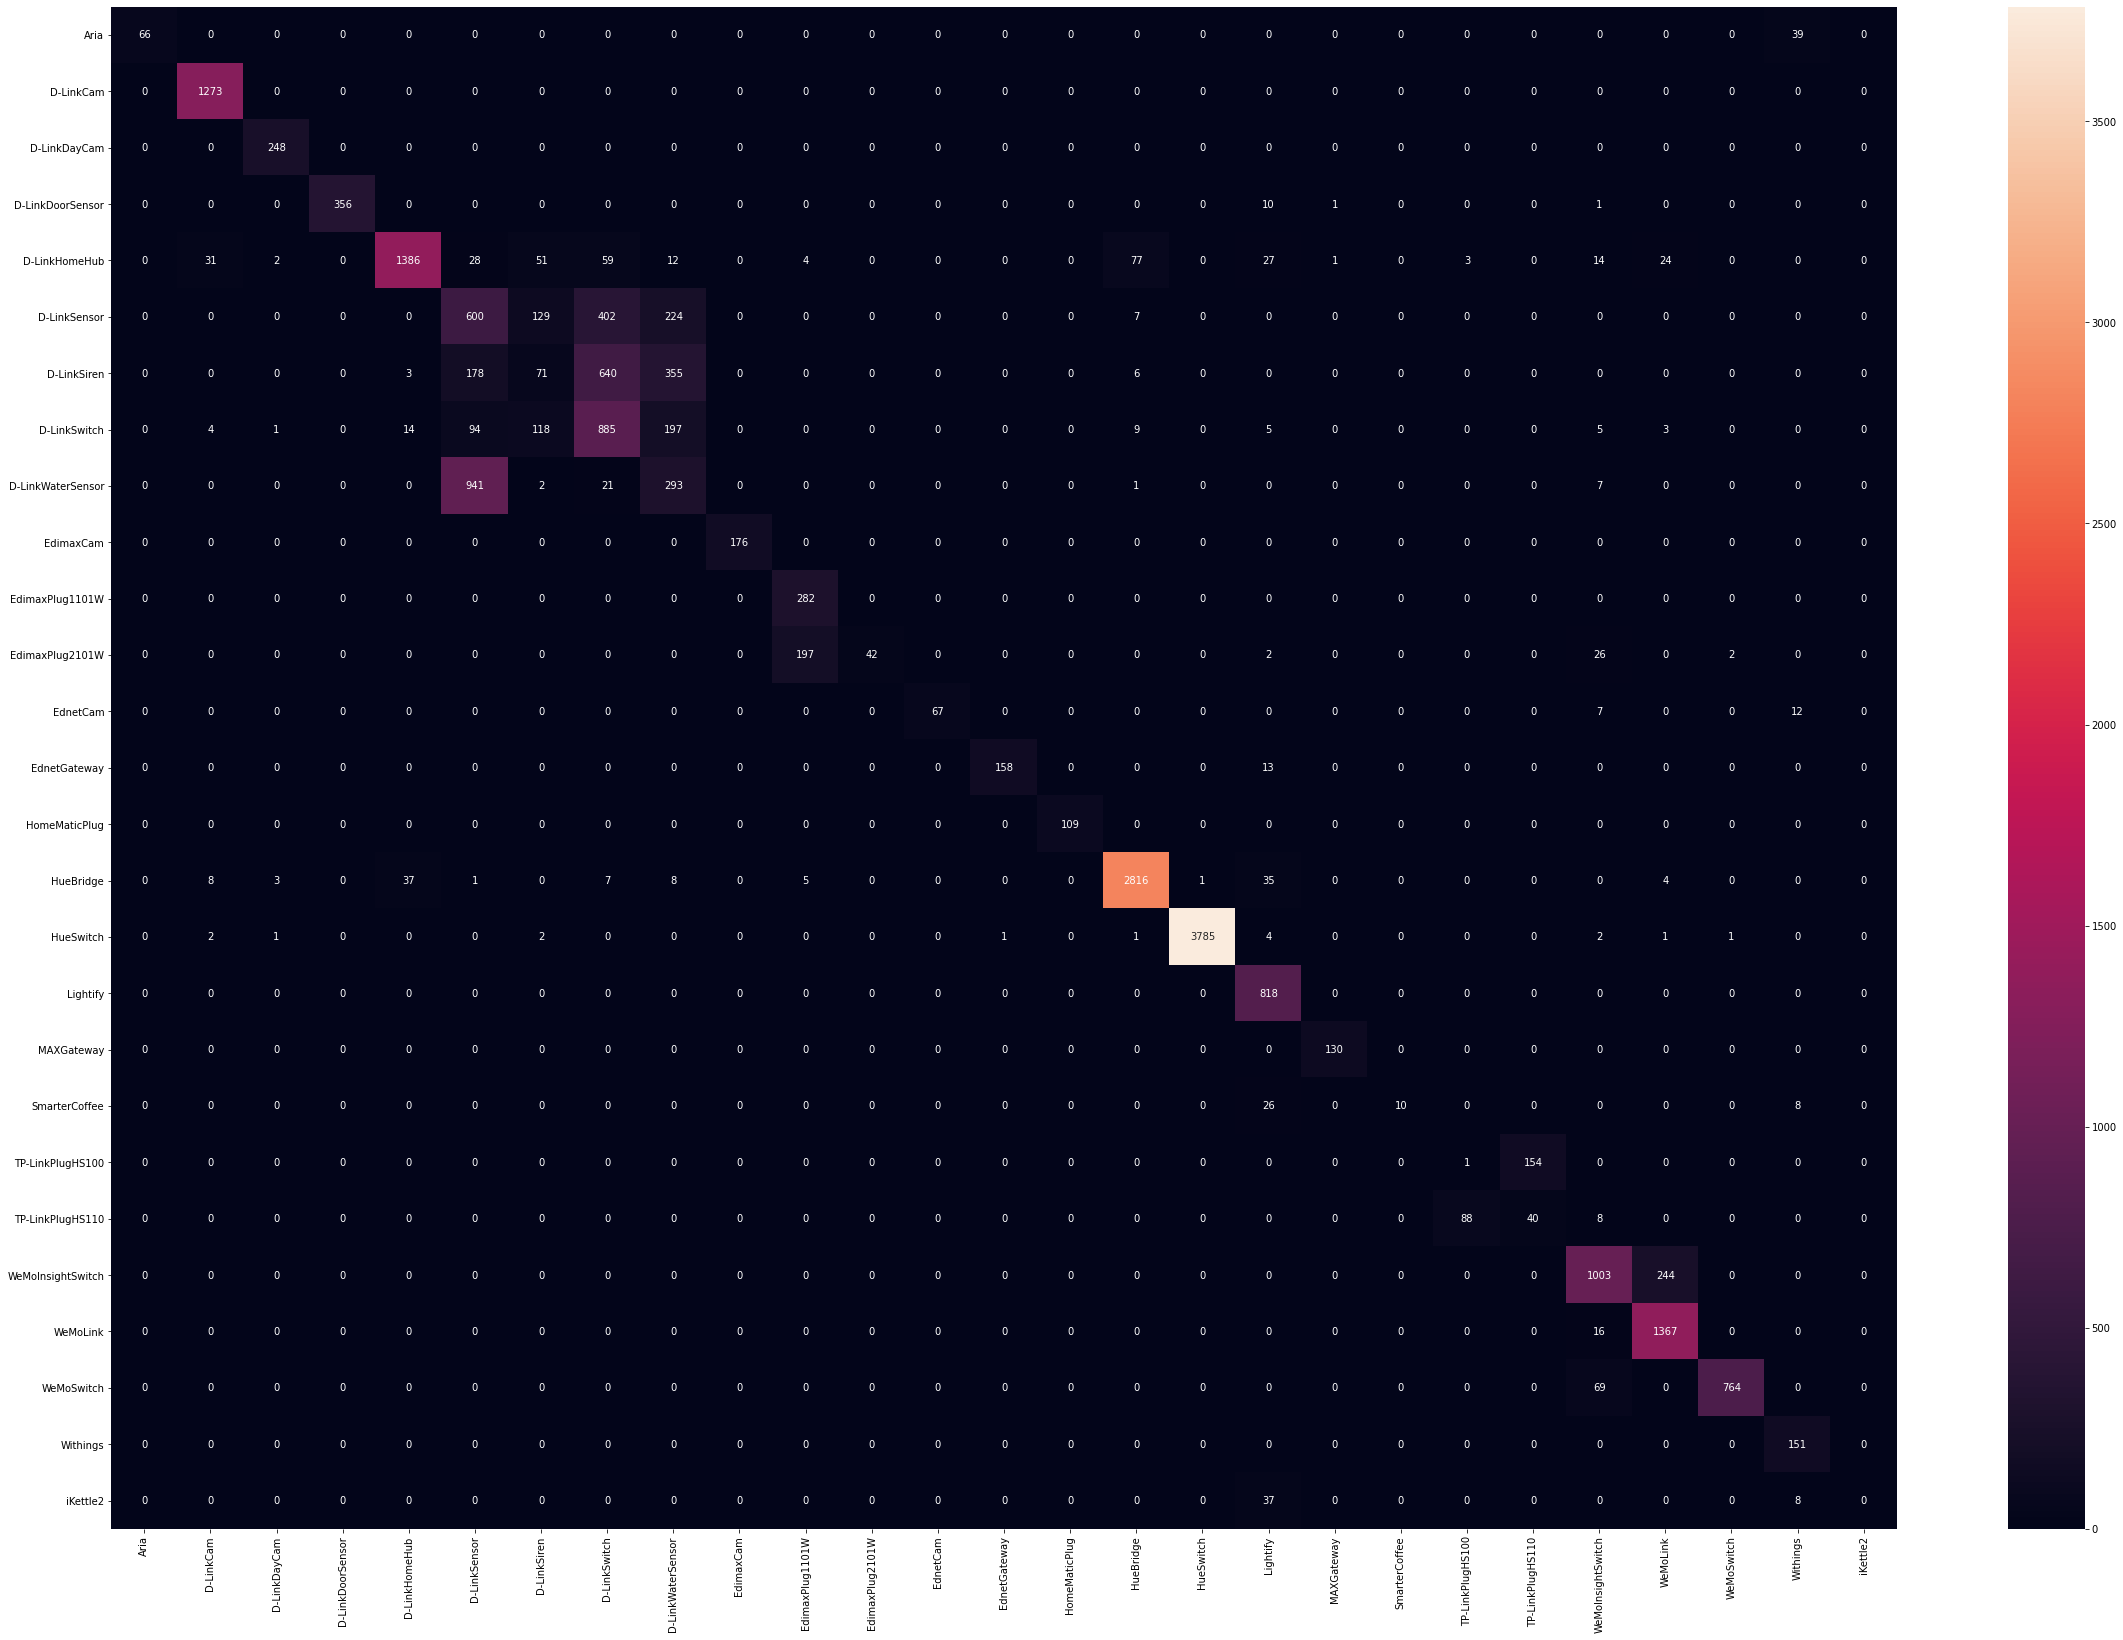

In [29]:
test='Aalto_IoTSentinel_Test.csv'
train='Aalto_IoTSentinel_Train.csv'


dataset="./sentinel/"
folder(dataset)

mixed=True
step=13
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


# IoTsense

In [11]:
feature= ['ARP', 'EAPOL', 'IP', 'ICMP', 'ICMP6', 'TCP', 'UDP', 'TCP_w_size',
       'HTTP', 'HTTPS', 'DHCP', 'BOOTP', 'SSDP', 'DNS', 'MDNS', 'NTP',
       'IP_padding', 'IP_ralert', 'payload_l', 'Entropy',"MAC", 'Label']

In [12]:
ml_list={"DT" :DecisionTreeClassifier(criterion='entropy', max_depth=27.0,
                       max_features=19,min_samples_split= 2)}
dataset="./Sense/"
folder(dataset)

###  IoTsense Normal Aagregeted Mixed

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Sense_1         0   1   DT      0.64  0.54  0.62  0.54  0.5611   0.61  0.14     0.0     0.14    0.0     
Sense_1         1   2   DT      0.64  0.54  0.62  0.54  0.5609   0.6   0.13     0.02    0.14    0.0     
Sense_1         2   3   DT      0.64  0.54  0.62  0.54  0.5605   0.6   0.14     0.02    0.15    0.0     
Sense_1         3   4   DT      0.64  0.54  0.62  0.54  0.5602   0.6   0.13     0.01    0.14    0.0     
Sense_1         4   5   DT      0.64  0.54  0.62  0.54  0.5606   0.6   0.14     0.02    0.16    0.0     
Sense_1         5   6   DT      0.64  0.54  0.62  0.54  0.5602   0.6   0.15     0.01    0.16    0.0     
Sense_1         6   7   DT      0.64  0.54  0.62  0.54  0.5611   0.61  0.17     0.0     0.17    0.0     
Sense_1         7   8   DT      0.64  0.54  0.62  0.54  0.561    0.6   0.15     0.0     0.15    0.0     
Sense_1         8   9   DT      0.64  0.54  0.62  0.54 

Sense_1         78  79  DT      0.64  0.54  0.62  0.54  0.5607   0.6   0.14     0.01    0.15    0.0     
Sense_1         79  80  DT      0.64  0.54  0.62  0.54  0.5607   0.61  0.14     0.0     0.14    0.0     
Sense_1         80  81  DT      0.64  0.54  0.62  0.54  0.5607   0.6   0.12     0.02    0.13    0.0     
Sense_1         81  82  DT      0.64  0.54  0.62  0.54  0.5611   0.6   0.15     0.01    0.15    0.0     
Sense_1         82  83  DT      0.64  0.54  0.62  0.54  0.5606   0.6   0.15     0.0     0.15    0.0     
Sense_1         83  84  DT      0.64  0.54  0.62  0.54  0.5609   0.6   0.14     0.02    0.16    0.0     
Sense_1         84  85  DT      0.64  0.54  0.62  0.54  0.5595   0.6   0.15     0.0     0.15    0.0     
Sense_1         85  86  DT      0.64  0.54  0.62  0.54  0.5604   0.6   0.13     0.0     0.13    0.0     
Sense_1         86  87  DT      0.64  0.54  0.62  0.54  0.5611   0.61  0.12     0.02    0.14    0.0     
Sense_1         87  88  DT      0.64  0.54  0.62  0.54 

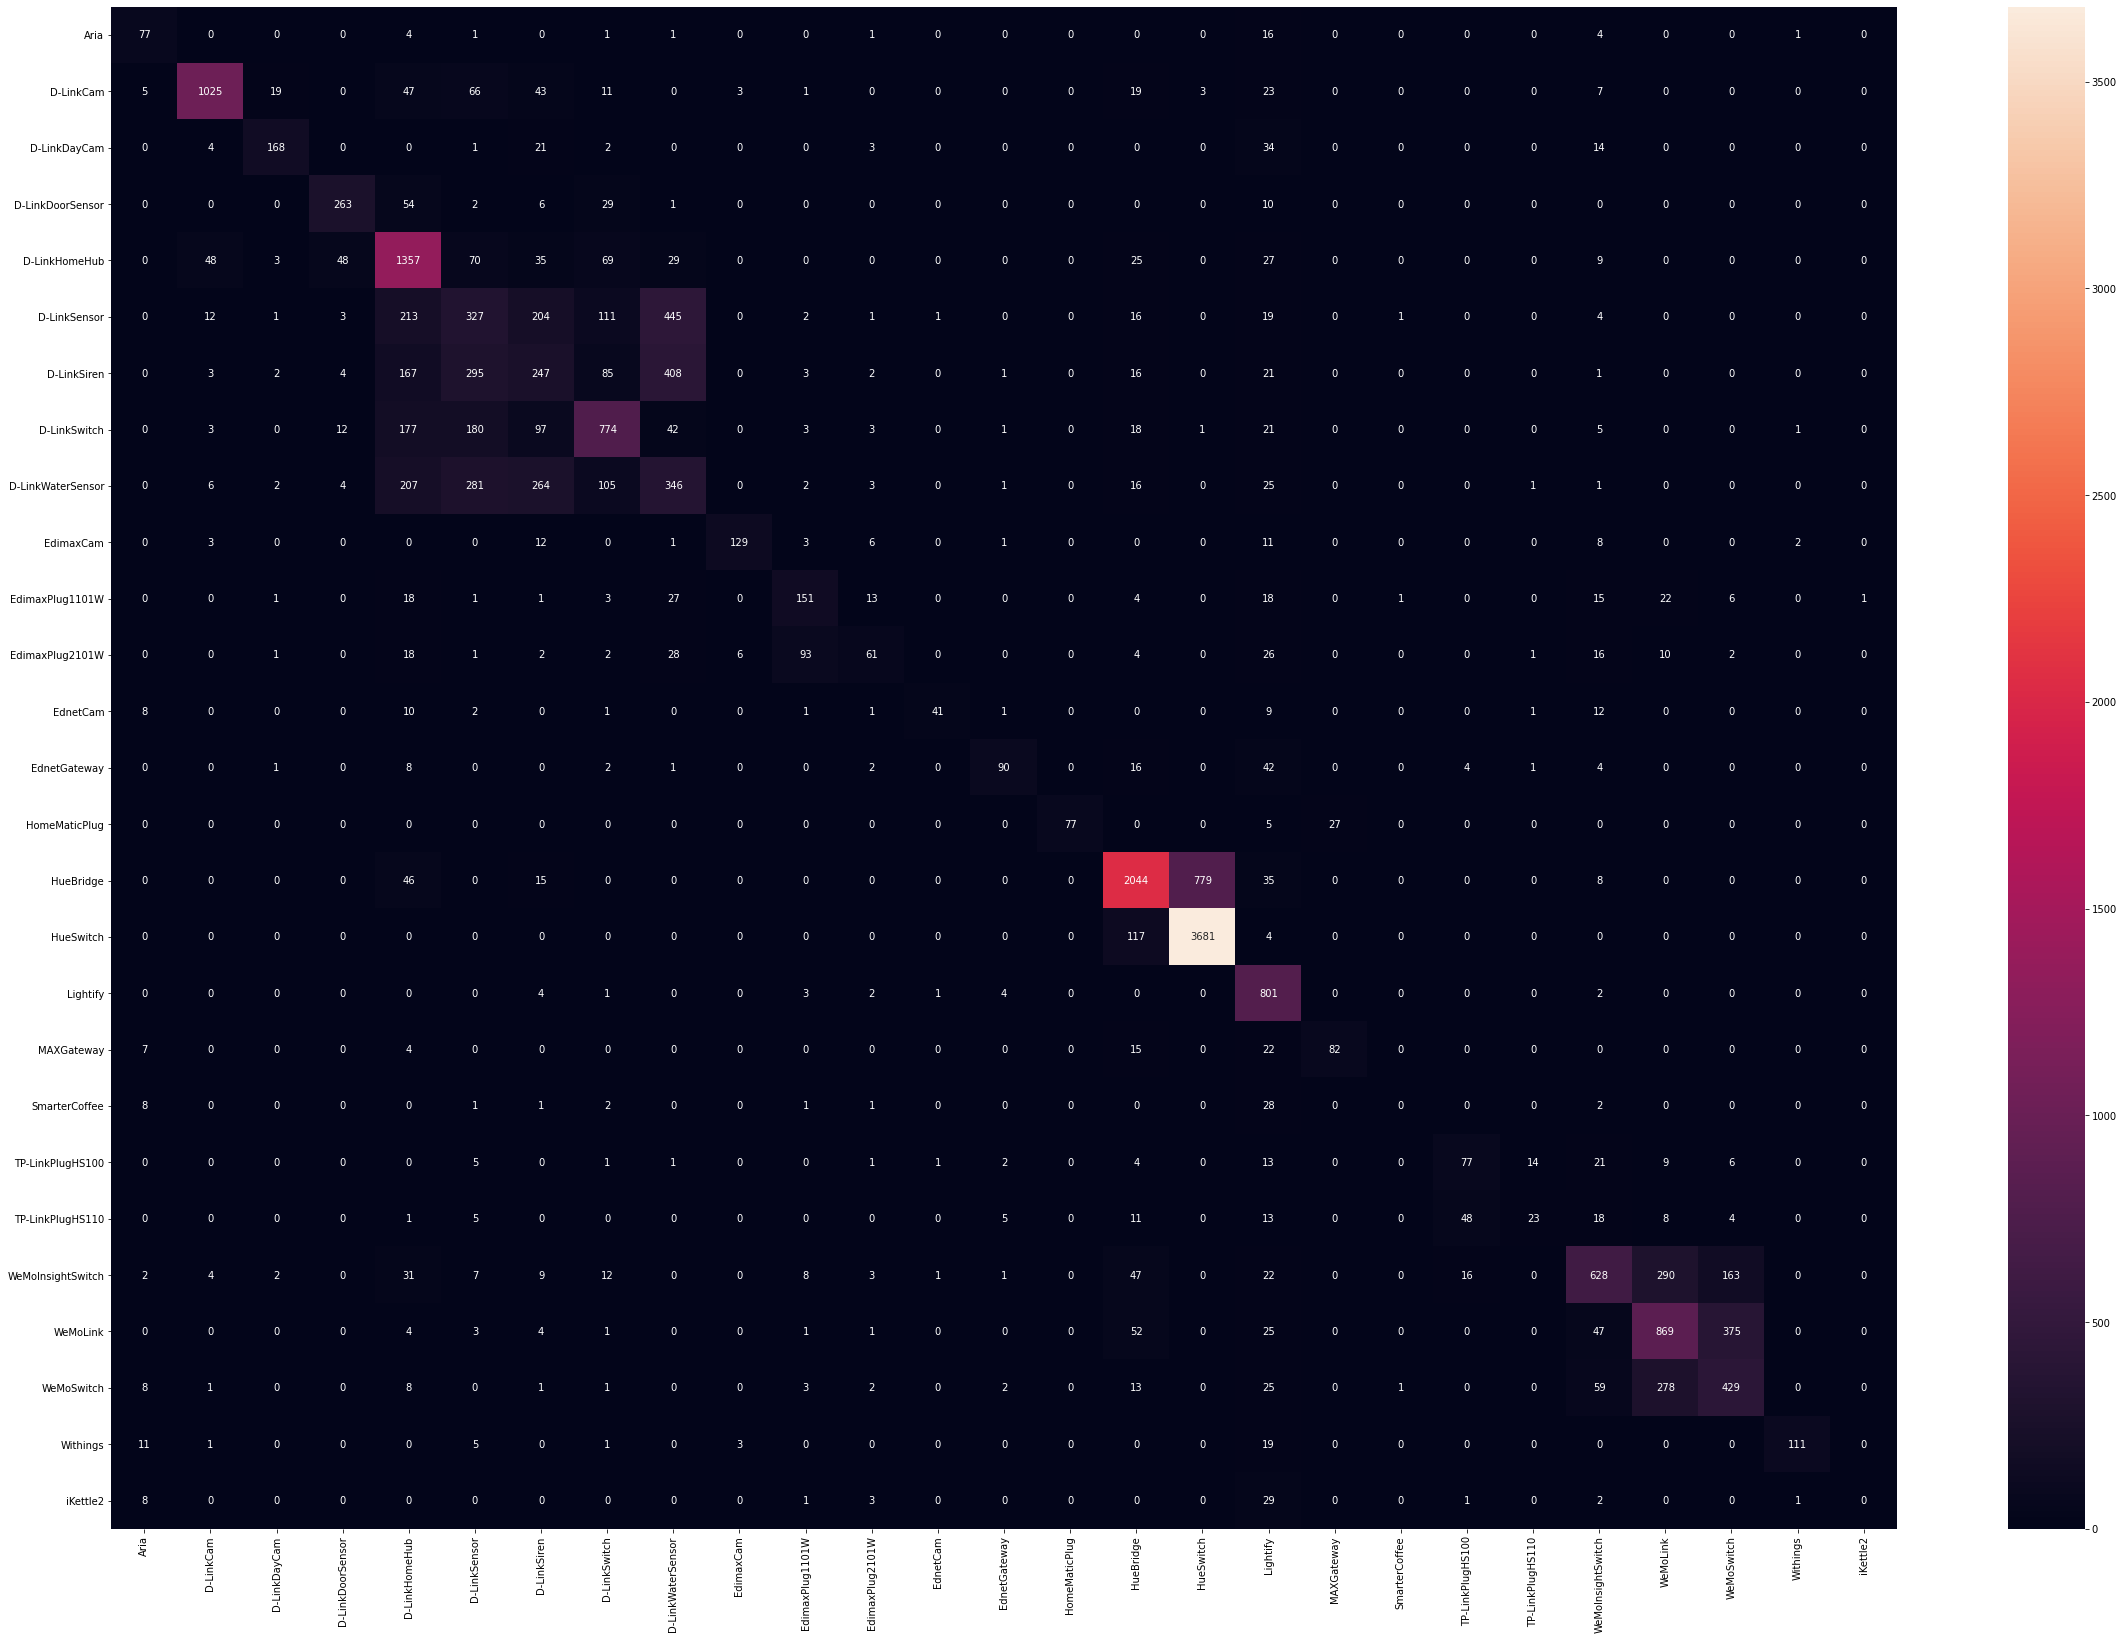

In [38]:
test='Aalto_IoTSense_Test.csv'
train='Aalto_IoTSense_Train.csv'



dataset="./Sense/"
folder(dataset)

mixed=False
step=1
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


###  IoTsense Aagregeted

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Sense_13        0   1   DT      0.67  0.68  0.72  0.68  0.6598   0.64  0.17     0.01    0.17    0.12    
Sense_13        1   2   DT      0.67  0.68  0.73  0.68  0.6615   0.64  0.14     0.01    0.15    0.12    
Sense_13        2   3   DT      0.67  0.67  0.73  0.67  0.6526   0.64  0.13     0.01    0.14    0.14    
Sense_13        3   4   DT      0.68  0.68  0.73  0.68  0.6582   0.64  0.13     0.01    0.13    0.12    
Sense_13        4   5   DT      0.67  0.67  0.72  0.67  0.6531   0.64  0.15     0.01    0.15    0.14    
Sense_13        5   6   DT      0.67  0.68  0.73  0.68  0.6615   0.64  0.14     0.01    0.14    0.14    
Sense_13        6   7   DT      0.67  0.67  0.72  0.67  0.6582   0.63  0.14     0.01    0.15    0.15    
Sense_13        7   8   DT      0.67  0.67  0.72  0.67  0.6546   0.64  0.16     0.01    0.16    0.15    
Sense_13        8   9   DT      0.67  0.67  0.72  0.67 

Sense_13        78  79  DT      0.67  0.68  0.72  0.68  0.6591   0.64  0.15     0.01    0.16    0.12    
Sense_13        79  80  DT      0.67  0.68  0.72  0.68  0.6618   0.64  0.28     0.01    0.28    0.2     
Sense_13        80  81  DT      0.67  0.68  0.71  0.68  0.6633   0.64  0.22     0.01    0.23    0.13    
Sense_13        81  82  DT      0.67  0.68  0.73  0.68  0.6625   0.64  0.17     0.01    0.18    0.19    
Sense_13        82  83  DT      0.67  0.68  0.71  0.68  0.6648   0.64  0.13     0.01    0.13    0.11    
Sense_13        83  84  DT      0.67  0.68  0.71  0.68  0.6546   0.64  0.15     0.01    0.15    0.13    
Sense_13        84  85  DT      0.67  0.68  0.71  0.68  0.6615   0.64  0.14     0.01    0.15    0.13    
Sense_13        85  86  DT      0.67  0.67  0.72  0.67  0.6574   0.64  0.14     0.01    0.14    0.12    
Sense_13        86  87  DT      0.67  0.68  0.73  0.68  0.6648   0.64  0.17     0.01    0.18    0.12    
Sense_13        87  88  DT      0.67  0.68  0.72  0.68 

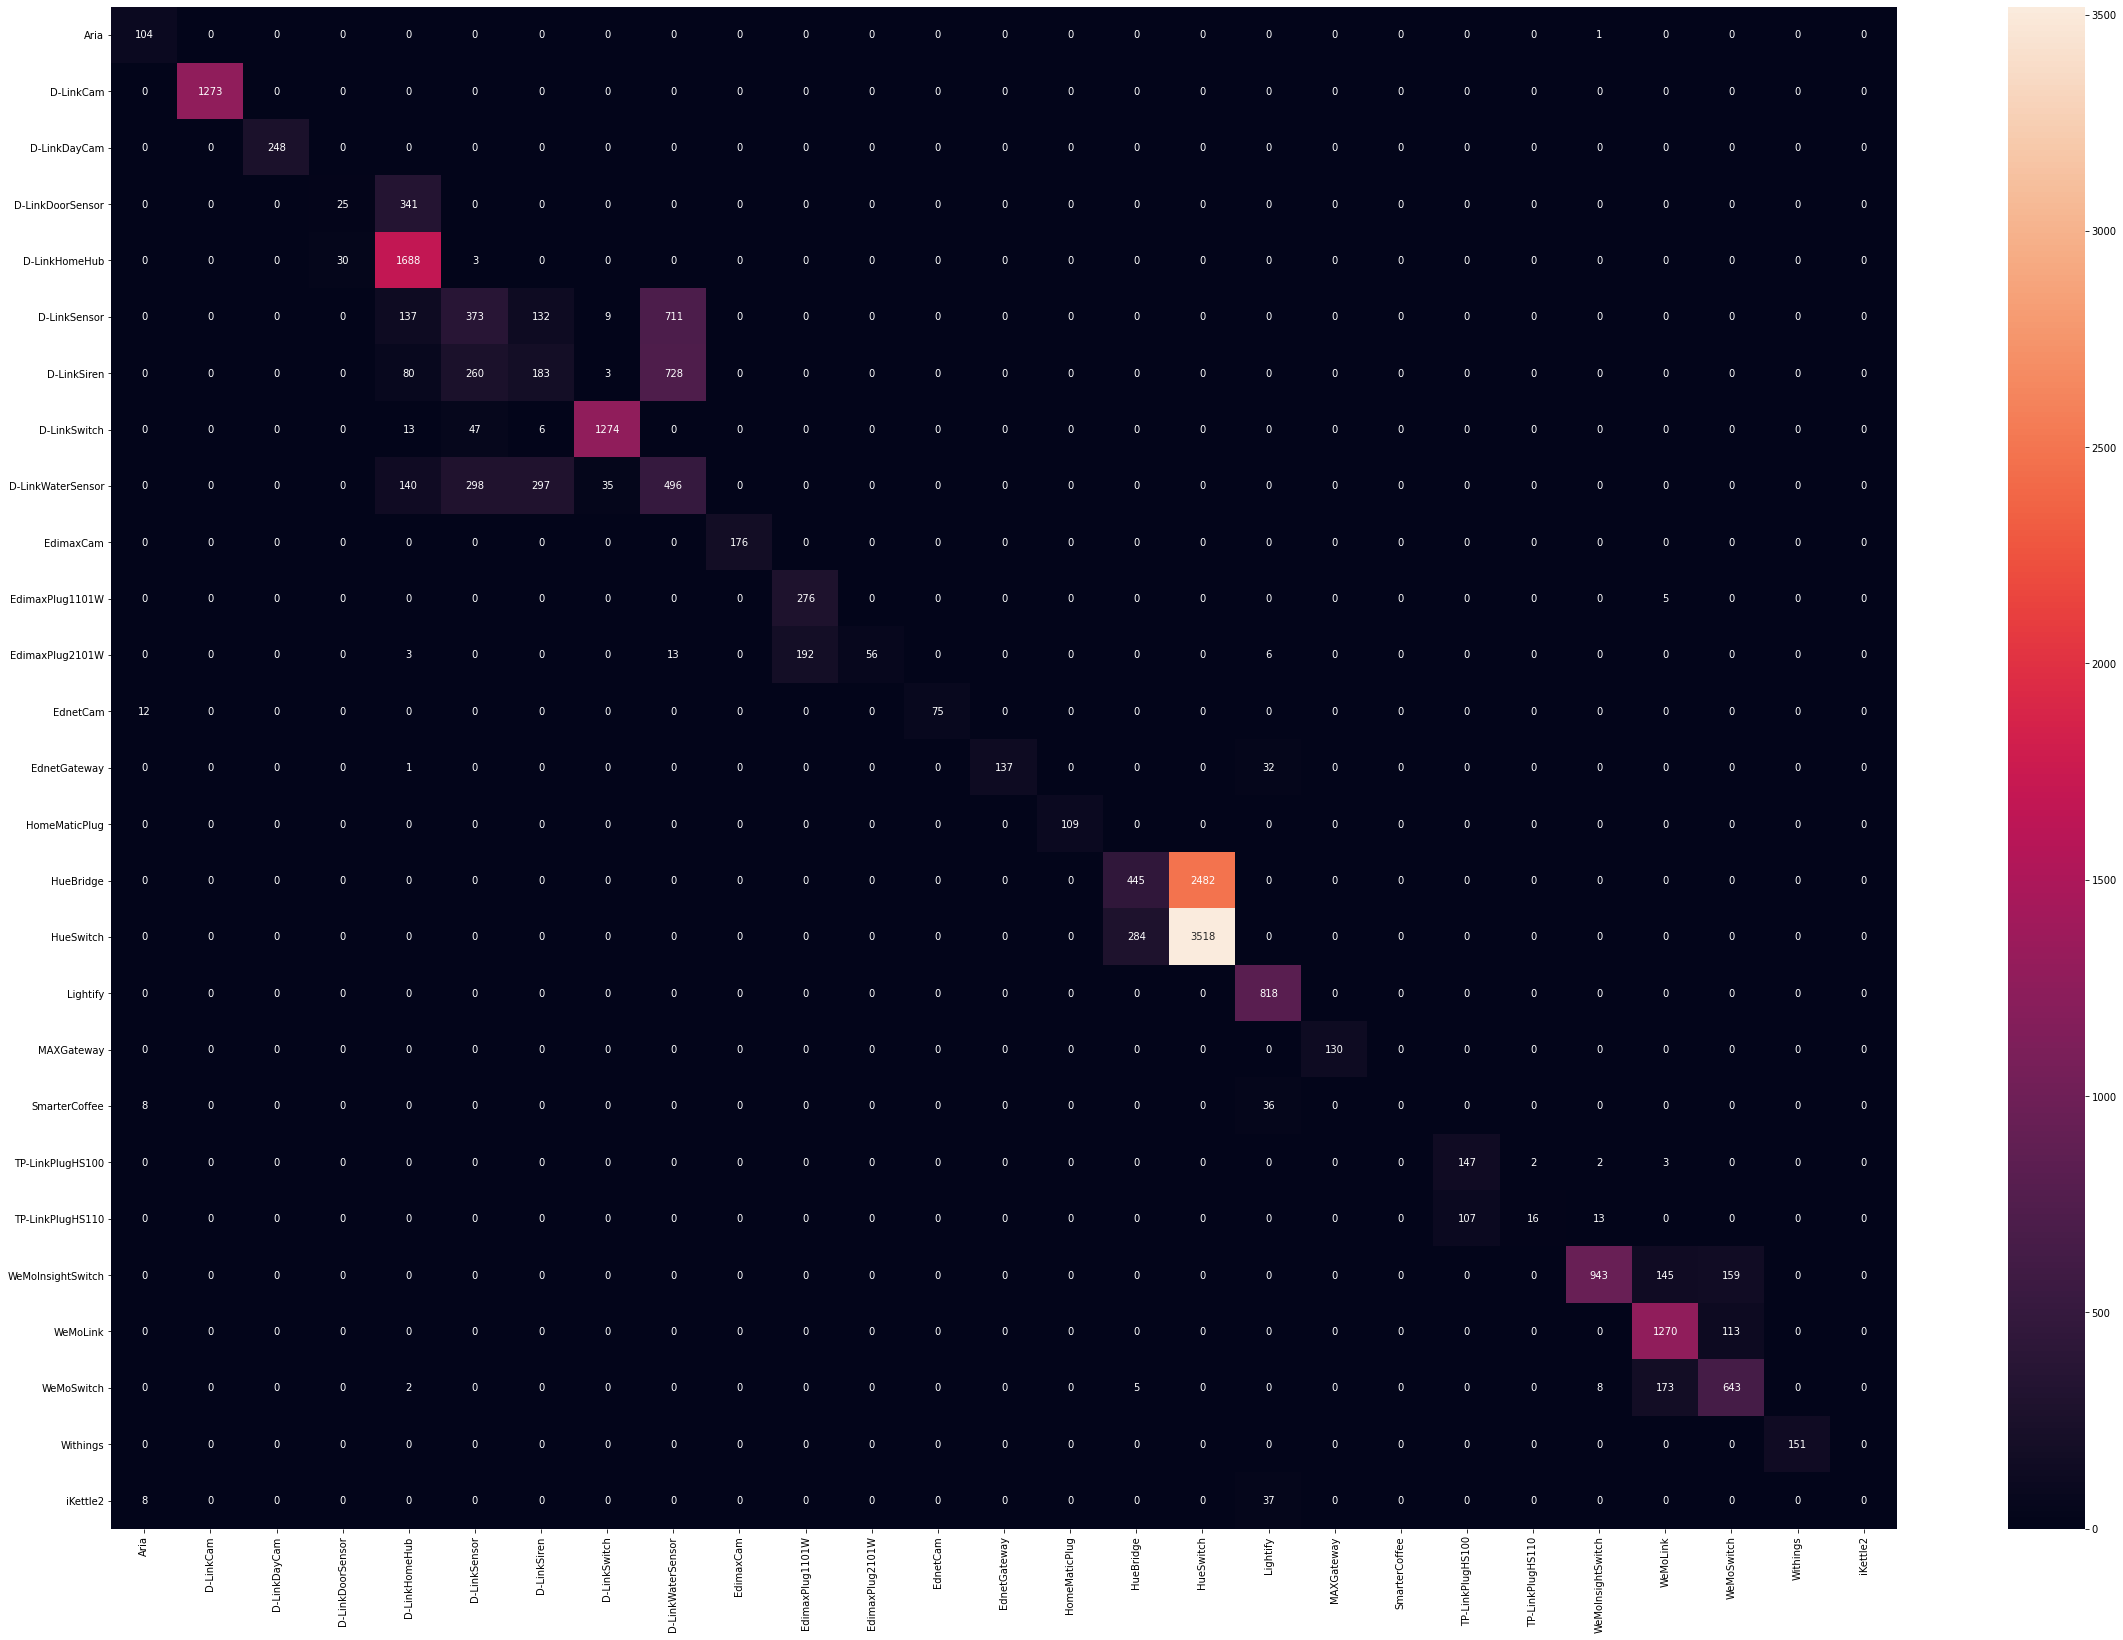

In [13]:
test='Aalto_IoTSense_Test.csv'
train='Aalto_IoTSense_Train.csv'

dataset="./Sense/"
folder(dataset)

mixed=False
step=13
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


###  IoTsense  Mixed

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Sense_13        0   1   DT      0.74  0.71  0.74  0.71  0.6955   0.72  0.15     0.01    0.16    0.18    
Sense_13        1   2   DT      0.75  0.71  0.73  0.71  0.6987   0.73  0.16     0.01    0.17    0.19    
Sense_13        2   3   DT      0.75  0.71  0.74  0.71  0.7008   0.72  0.14     0.01    0.15    0.17    
Sense_13        3   4   DT      0.75  0.71  0.74  0.71  0.7033   0.72  0.16     0.01    0.17    0.18    
Sense_13        4   5   DT      0.75  0.72  0.75  0.72  0.7062   0.72  0.14     0.01    0.15    0.17    
Sense_13        5   6   DT      0.75  0.72  0.75  0.72  0.7085   0.73  0.16     0.01    0.16    0.18    
Sense_13        6   7   DT      0.74  0.71  0.74  0.71  0.6945   0.72  0.15     0.01    0.16    0.2     
Sense_13        7   8   DT      0.74  0.71  0.75  0.71  0.6956   0.72  0.15     0.01    0.15    0.18    
Sense_13        8   9   DT      0.74  0.71  0.75  0.71 

Sense_13        78  79  DT      0.75  0.71  0.75  0.71  0.7013   0.73  0.15     0.01    0.16    0.17    
Sense_13        79  80  DT      0.75  0.72  0.73  0.72  0.7001   0.73  0.16     0.01    0.16    0.19    
Sense_13        80  81  DT      0.74  0.71  0.75  0.71  0.7032   0.72  0.15     0.01    0.16    0.15    
Sense_13        81  82  DT      0.75  0.71  0.75  0.71  0.6986   0.73  0.14     0.01    0.15    0.28    
Sense_13        82  83  DT      0.75  0.72  0.75  0.72  0.7022   0.73  0.12     0.01    0.13    0.17    
Sense_13        83  84  DT      0.75  0.71  0.75  0.71  0.7066   0.72  0.14     0.01    0.15    0.16    
Sense_13        84  85  DT      0.75  0.71  0.73  0.71  0.6959   0.72  0.14     0.01    0.14    0.15    
Sense_13        85  86  DT      0.75  0.71  0.75  0.71  0.6947   0.72  0.14     0.01    0.15    0.17    
Sense_13        86  87  DT      0.75  0.72  0.74  0.72  0.7094   0.73  0.14     0.01    0.15    0.21    
Sense_13        87  88  DT      0.75  0.72  0.75  0.72 

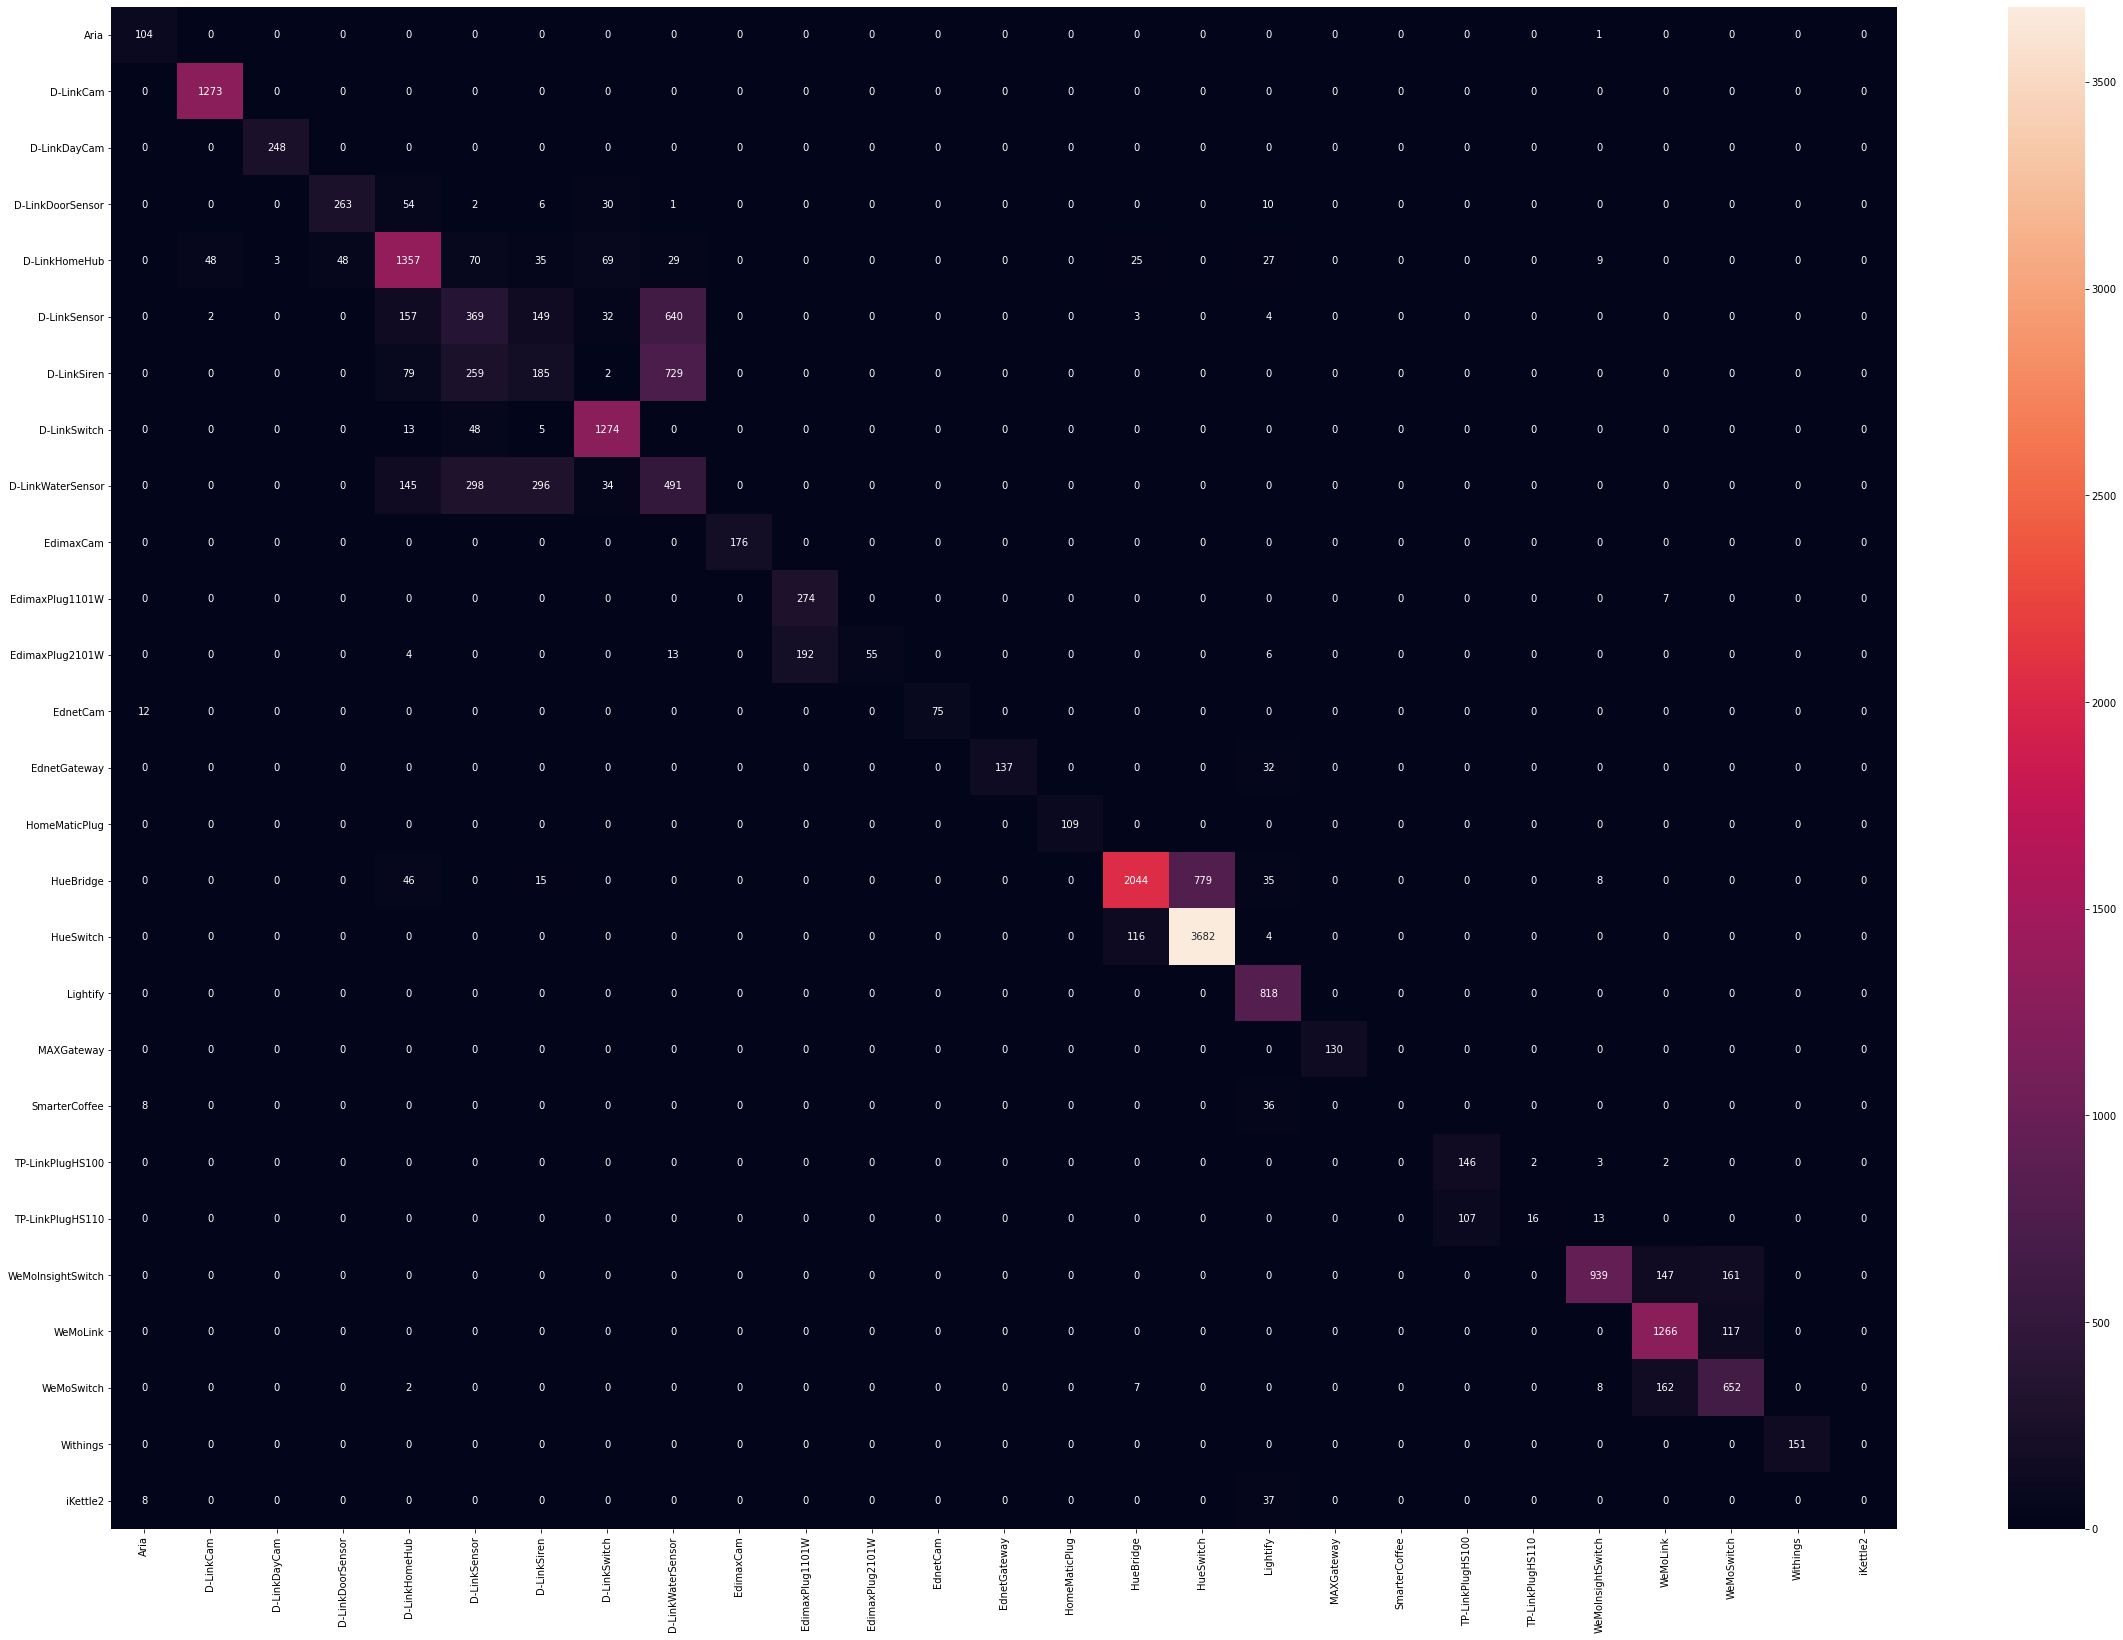

In [14]:
test='Aalto_IoTSense_Test.csv'
train='Aalto_IoTSense_Train.csv'



dataset="./Sense/"
folder(dataset)

mixed=True
step=13
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


# IoTDevID

In [13]:
feature= ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_dataofs', 'TCP_FIN', 'TCP_ACK', 'TCP_window', 'UDP_len', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_qdcount', 'dport_class', 'payload_bytes', 'entropy',
"MAC",
          'Label']

In [14]:
ml_list={"DT" :DecisionTreeClassifier(criterion='gini', max_depth=26.0,
                       max_features=26,min_samples_split= 6)}

dataset="./IoTDevID/"
folder(dataset)

###  IoTDevID Normal

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
IoTDevID_1      0   1   DT      0.71  0.71  0.77  0.71  0.7275   0.68  0.16     0.0     0.16    0.0     
IoTDevID_1      1   2   DT      0.71  0.71  0.78  0.71  0.7287   0.68  0.15     0.0     0.15    0.0     
IoTDevID_1      2   3   DT      0.7   0.7   0.77  0.7   0.7245   0.68  0.16     0.01    0.17    0.0     
IoTDevID_1      3   4   DT      0.7   0.7   0.77  0.7   0.7264   0.67  0.15     0.01    0.16    0.0     
IoTDevID_1      4   5   DT      0.7   0.71  0.78  0.71  0.7278   0.68  0.16     0.01    0.17    0.0     
IoTDevID_1      5   6   DT      0.71  0.71  0.78  0.71  0.7292   0.68  0.15     0.01    0.17    0.0     
IoTDevID_1      6   7   DT      0.71  0.71  0.78  0.71  0.7289   0.68  0.16     0.0     0.16    0.0     
IoTDevID_1      7   8   DT      0.71  0.71  0.78  0.71  0.7282   0.68  0.15     0.02    0.17    0.0     
IoTDevID_1      8   9   DT      0.71  0.71  0.77  0.71 

IoTDevID_1      78  79  DT      0.71  0.7   0.77  0.7   0.7248   0.68  0.16     0.0     0.16    0.0     
IoTDevID_1      79  80  DT      0.71  0.71  0.78  0.71  0.7278   0.68  0.16     0.0     0.16    0.0     
IoTDevID_1      80  81  DT      0.7   0.71  0.77  0.71  0.7273   0.68  0.15     0.01    0.16    0.0     
IoTDevID_1      81  82  DT      0.7   0.71  0.78  0.71  0.7278   0.68  0.15     0.0     0.15    0.0     
IoTDevID_1      82  83  DT      0.71  0.71  0.78  0.71  0.7284   0.68  0.15     0.0     0.15    0.0     
IoTDevID_1      83  84  DT      0.7   0.7   0.77  0.7   0.7256   0.68  0.17     0.0     0.17    0.0     
IoTDevID_1      84  85  DT      0.7   0.7   0.78  0.7   0.7274   0.68  0.22     0.0     0.22    0.0     
IoTDevID_1      85  86  DT      0.71  0.71  0.78  0.71  0.7279   0.68  0.17     0.0     0.17    0.0     
IoTDevID_1      86  87  DT      0.71  0.71  0.78  0.71  0.7289   0.68  0.15     0.01    0.16    0.0     
IoTDevID_1      87  88  DT      0.71  0.71  0.77  0.71 

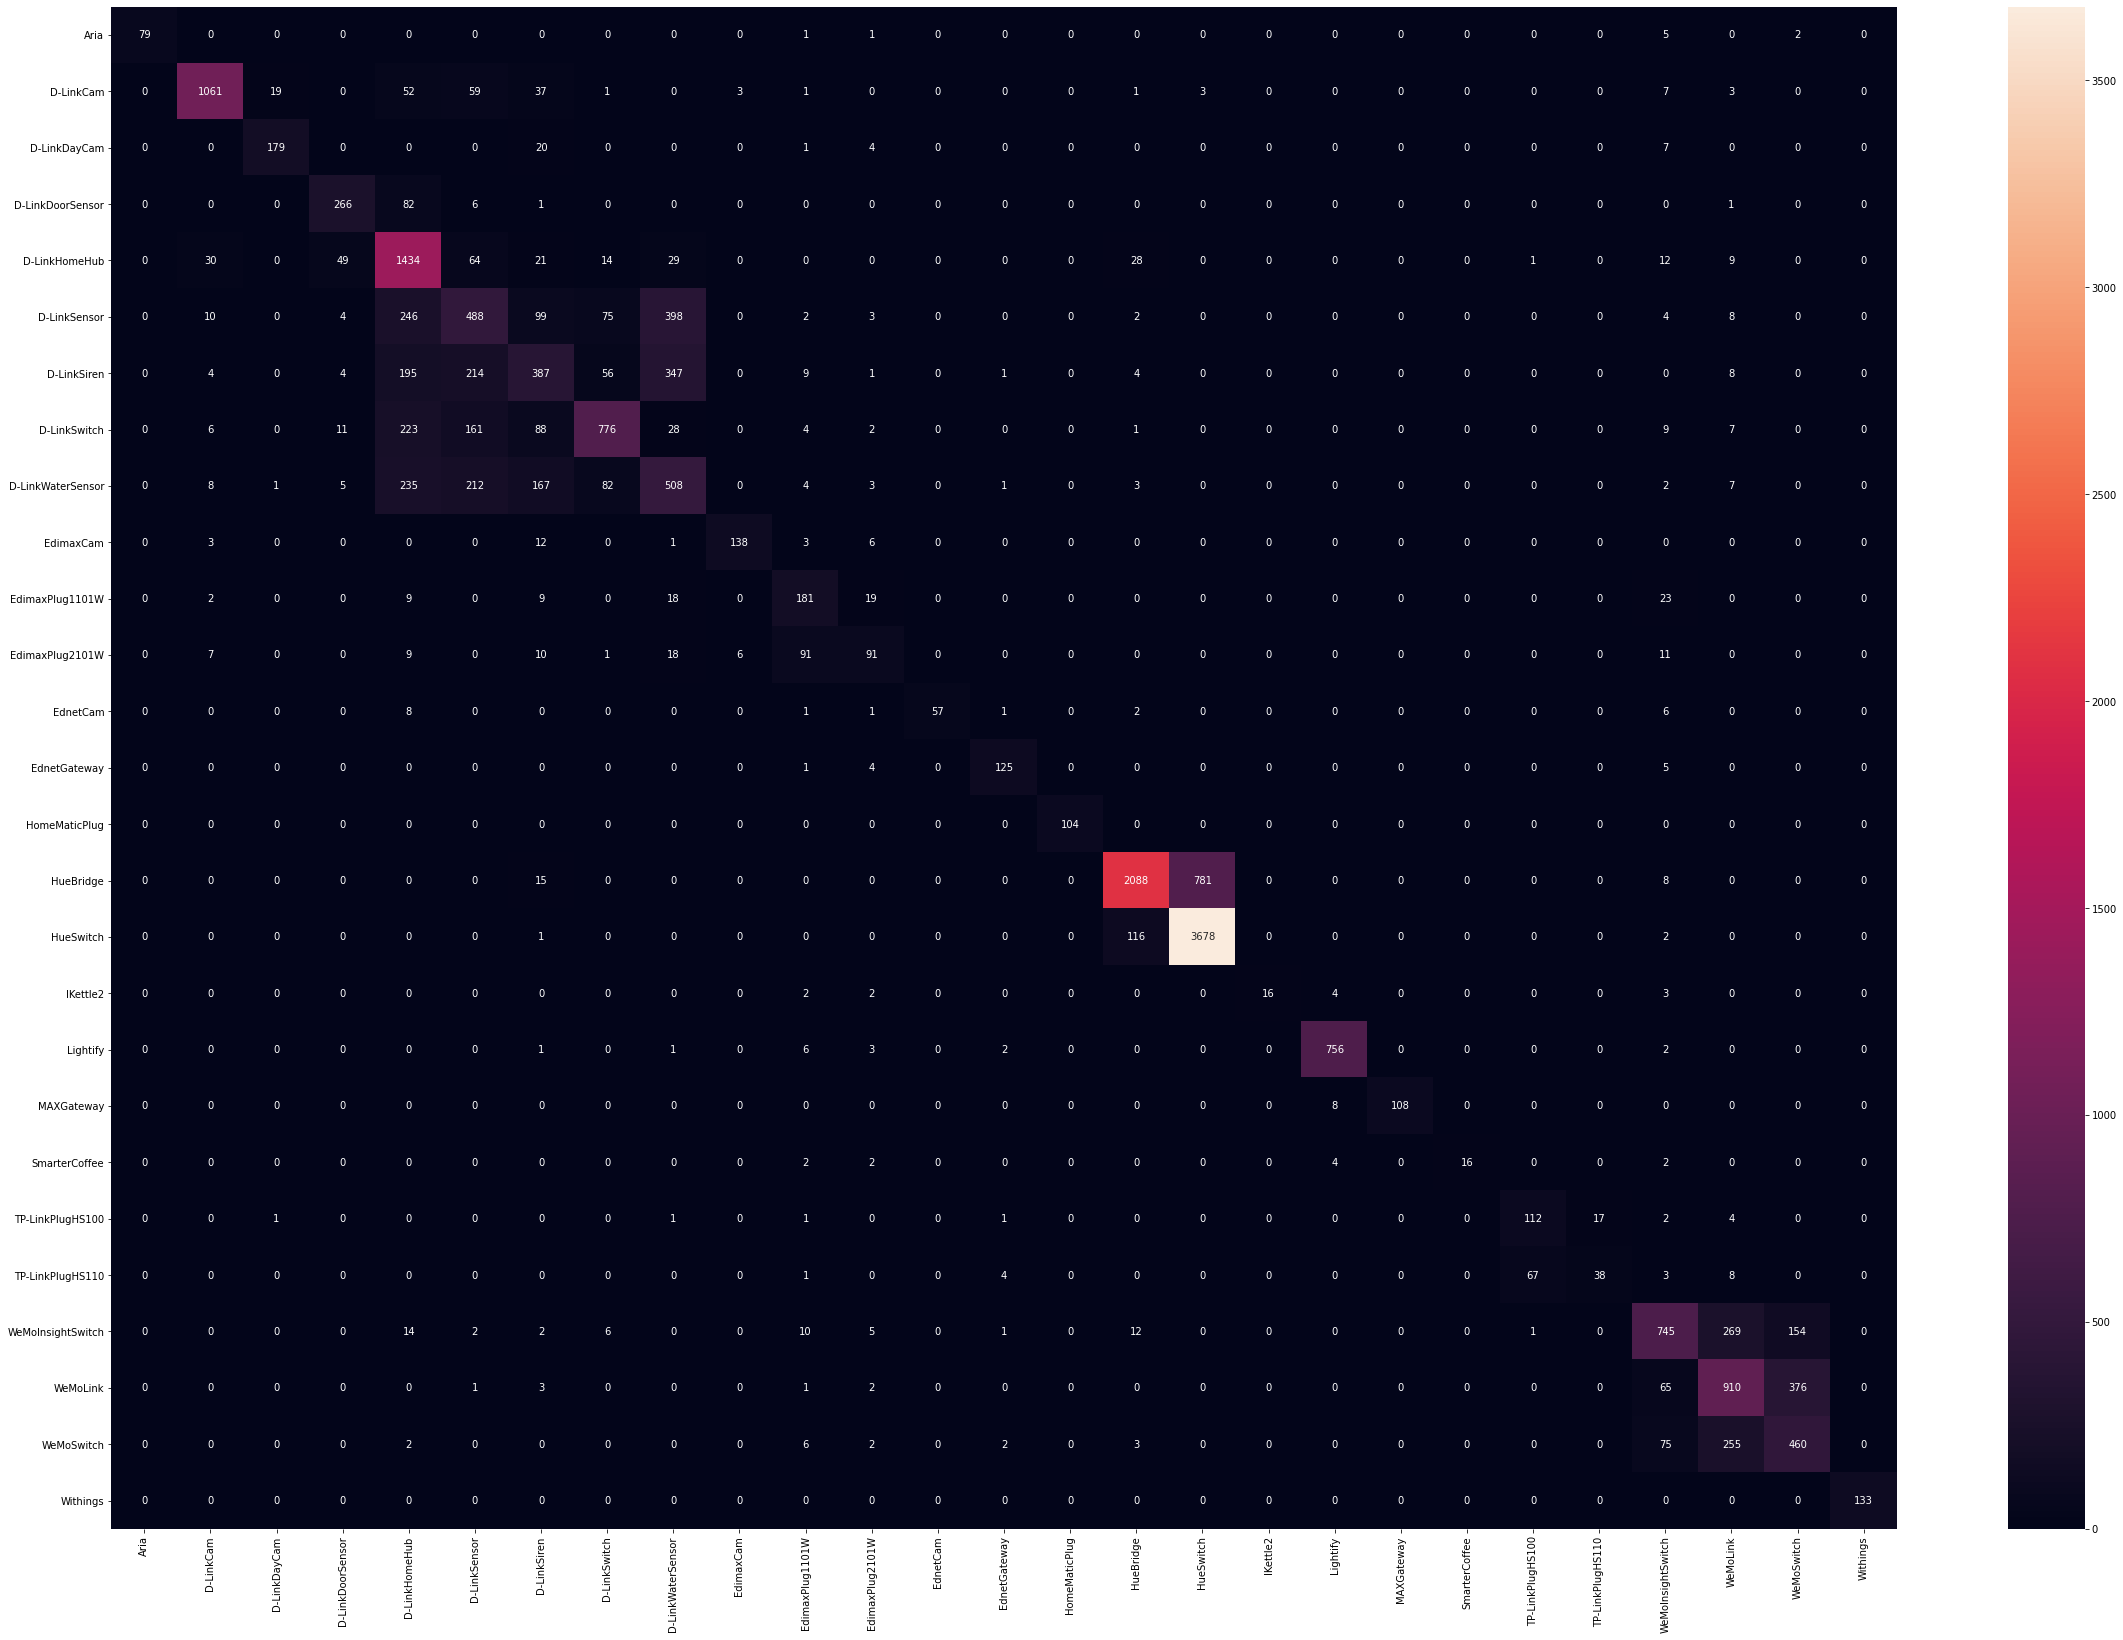

In [15]:
test='Aalto_test_IoTDevID.csv'
train='Aalto_train_IoTDevID.csv'




dataset="./IoTDevID/"
folder(dataset)

mixed=False
step=1
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


###  IoTDevID  Aagregeted

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
IoTDevID_13     0   1   DT      0.75  0.82  0.87  0.82  0.8092   0.72  0.17     0.0     0.17    0.12    
IoTDevID_13     1   2   DT      0.74  0.82  0.86  0.82  0.8061   0.72  0.15     0.02    0.16    0.14    
IoTDevID_13     2   3   DT      0.74  0.81  0.87  0.81  0.8      0.72  0.15     0.02    0.16    0.12    
IoTDevID_13     3   4   DT      0.74  0.82  0.87  0.82  0.8071   0.72  0.15     0.02    0.16    0.1     
IoTDevID_13     4   5   DT      0.75  0.82  0.87  0.82  0.8119   0.72  0.15     0.0     0.15    0.15    
IoTDevID_13     5   6   DT      0.74  0.82  0.87  0.82  0.8071   0.72  0.15     0.02    0.16    0.12    
IoTDevID_13     6   7   DT      0.75  0.82  0.87  0.82  0.8142   0.72  0.16     0.0     0.16    0.12    
IoTDevID_13     7   8   DT      0.74  0.82  0.87  0.82  0.8126   0.72  0.15     0.01    0.16    0.12    
IoTDevID_13     8   9   DT      0.75  0.82  0.87  0.82 

IoTDevID_13     78  79  DT      0.75  0.82  0.87  0.82  0.8119   0.73  0.15     0.01    0.16    0.13    
IoTDevID_13     79  80  DT      0.75  0.82  0.87  0.82  0.8118   0.72  0.15     0.01    0.16    0.14    
IoTDevID_13     80  81  DT      0.74  0.82  0.87  0.82  0.8059   0.72  0.15     0.01    0.16    0.14    
IoTDevID_13     81  82  DT      0.75  0.82  0.87  0.82  0.8106   0.72  0.16     0.01    0.16    0.14    
IoTDevID_13     82  83  DT      0.75  0.82  0.87  0.82  0.8105   0.72  0.15     0.01    0.16    0.12    
IoTDevID_13     83  84  DT      0.75  0.82  0.87  0.82  0.8025   0.72  0.16     0.01    0.17    0.12    
IoTDevID_13     84  85  DT      0.75  0.82  0.86  0.82  0.8057   0.72  0.19     0.01    0.2     0.15    
IoTDevID_13     85  86  DT      0.74  0.82  0.86  0.82  0.8058   0.71  0.16     0.01    0.17    0.13    
IoTDevID_13     86  87  DT      0.75  0.82  0.87  0.82  0.8078   0.72  0.26     0.01    0.27    0.17    
IoTDevID_13     87  88  DT      0.75  0.83  0.87  0.83 

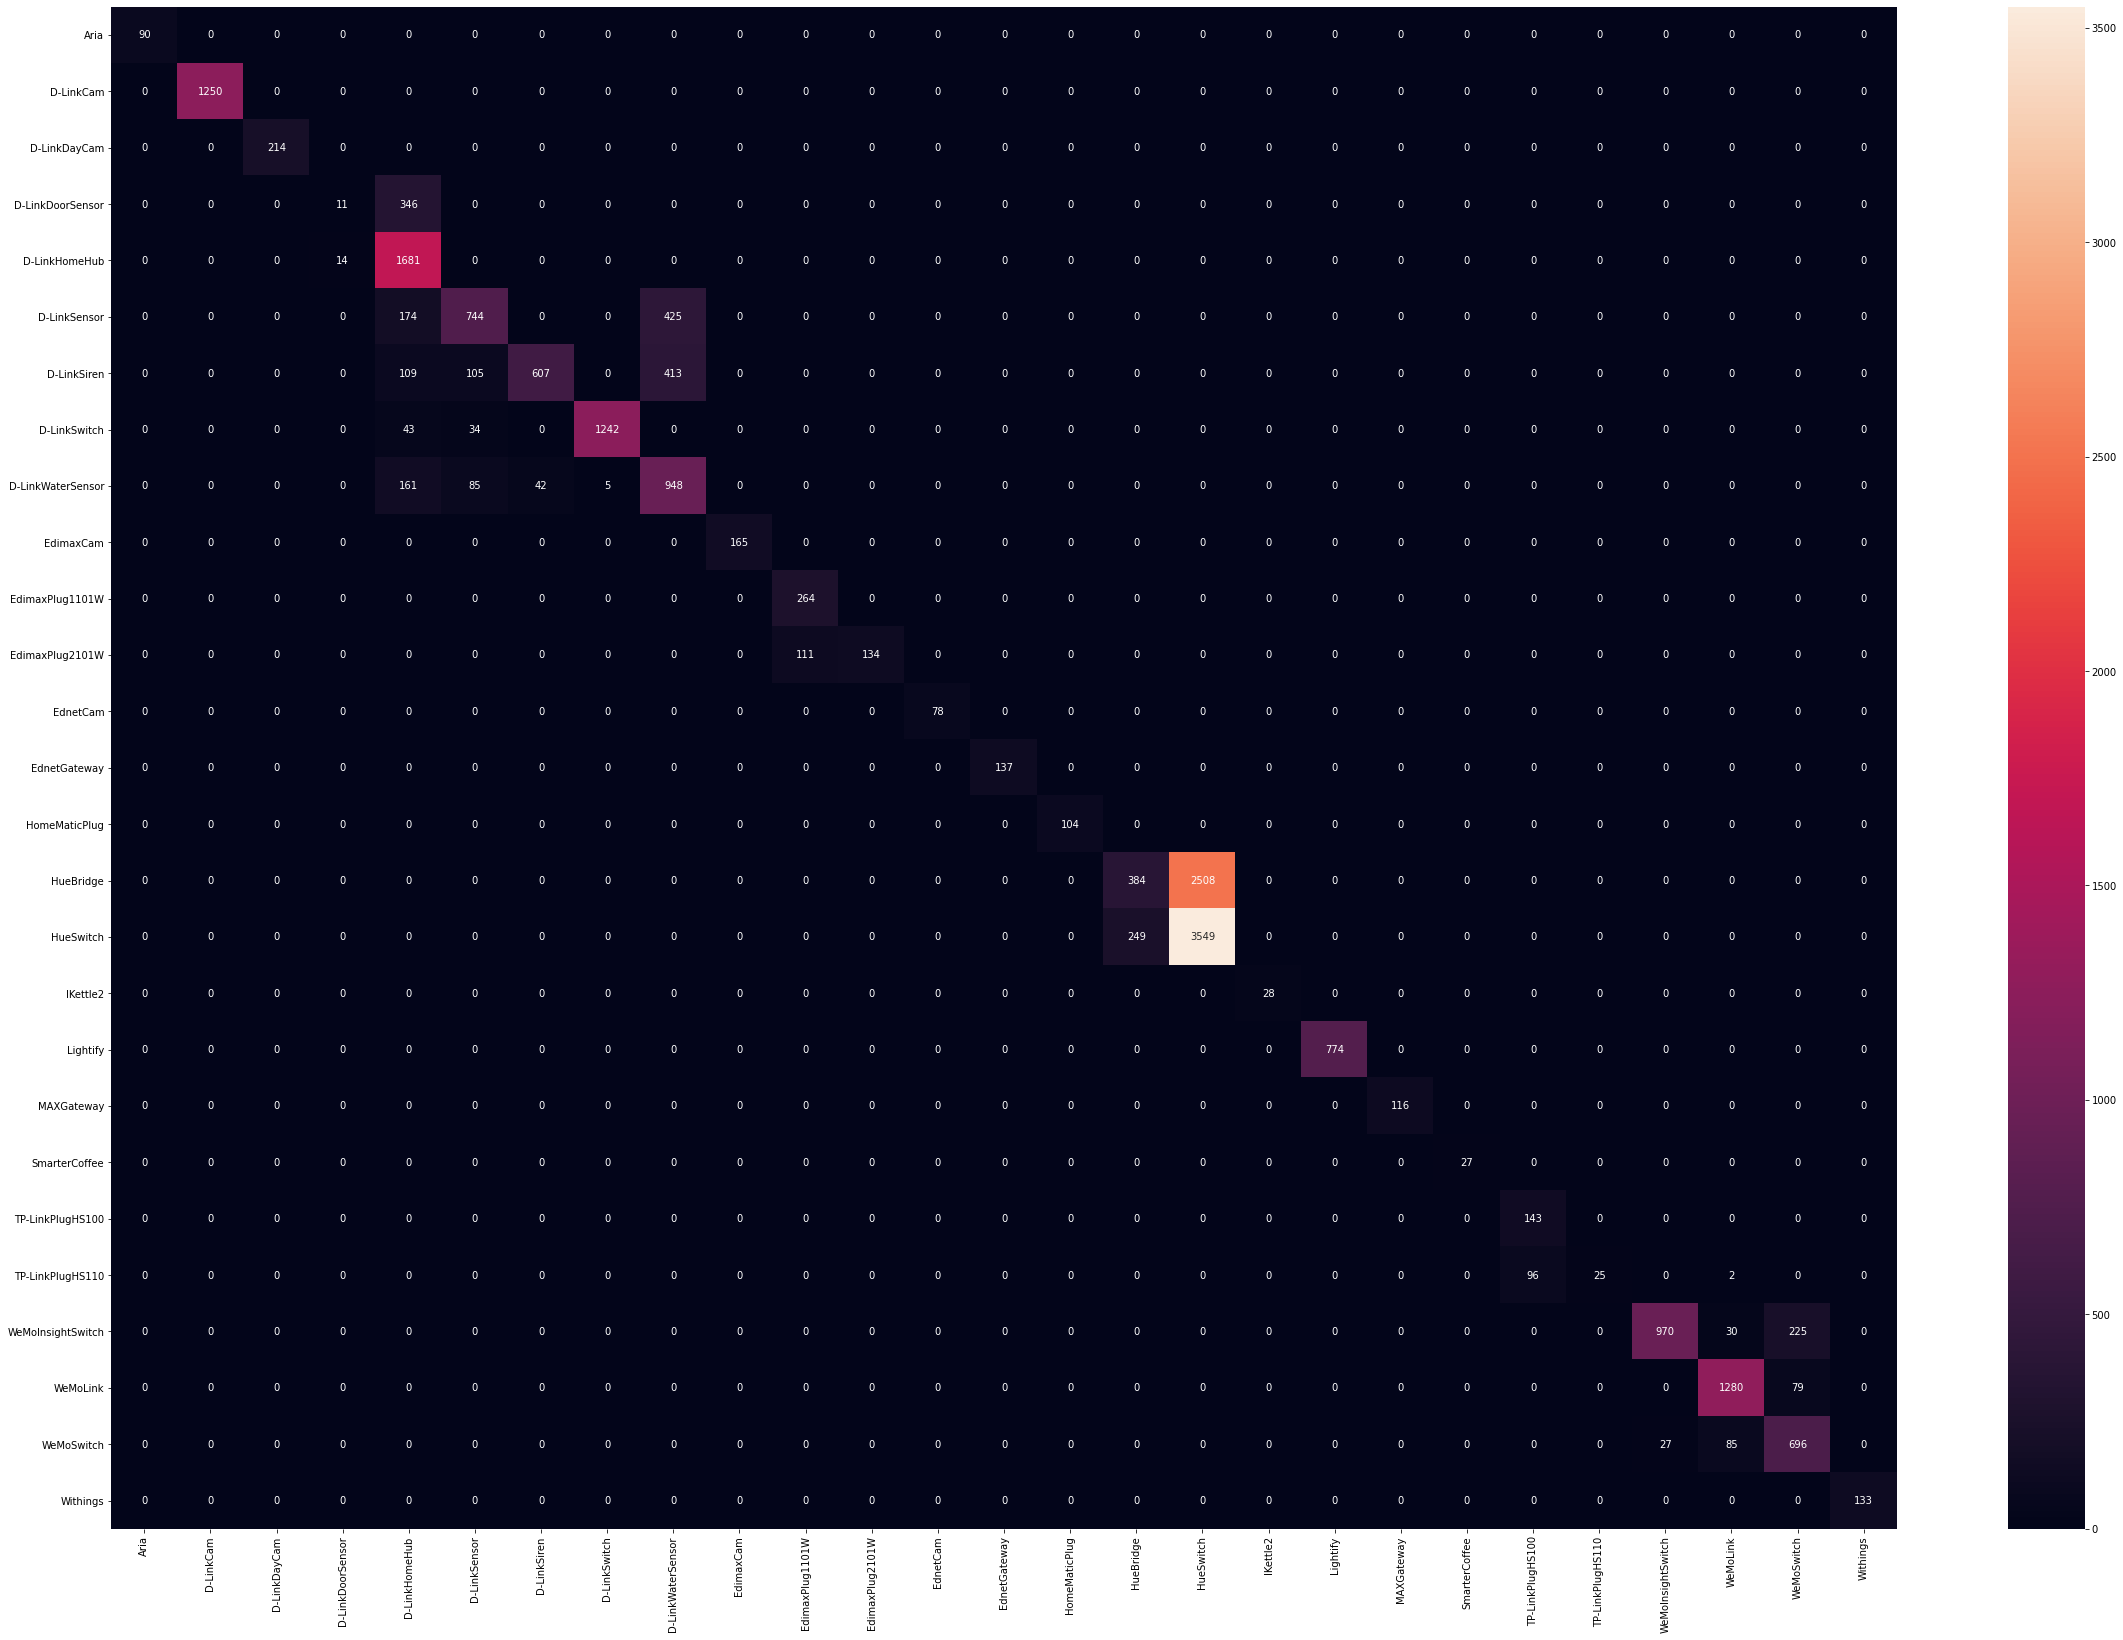

In [16]:
dataset="./IoTDevID/"
folder(dataset)

mixed=False
step=13
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


###  IoTDevID  Mixed

In [ ]:

dataset="./IoTDevID/"
folder(dataset)

mixed=True
step=13
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
IoTDevID_13     0   1   DT      0.84  0.87  0.9   0.87  0.8641   0.82  0.17     0.01    0.17    0.28    
IoTDevID_13     1   2   DT      0.83  0.86  0.9   0.86  0.8564   0.81  0.16     0.01    0.17    0.18    
IoTDevID_13     2   3   DT      0.83  0.87  0.9   0.87  0.8636   0.82  0.15     0.01    0.16    0.16    
IoTDevID_13     3   4   DT      0.83  0.85  0.89  0.85  0.8484   0.81  0.17     0.01    0.17    0.17    
IoTDevID_13     4   5   DT      0.83  0.86  0.9   0.86  0.8509   0.82  0.17     0.01    0.17    0.15    
IoTDevID_13     5   6   DT      0.83  0.86  0.9   0.86  0.8496   0.81  0.15     0.01    0.15    0.15    
IoTDevID_13     6   7   DT      0.84  0.87  0.9   0.87  0.8655   0.82  0.16     0.01    0.16    0.14    
IoTDevID_13     7   8   DT      0.84  0.87  0.9   0.87  0.866    0.82  0.16     0.01    0.16    0.16    
IoTDevID_13     8   9   DT      0.83  0.86  0.9   0.86 

IoTDevID_13     78  79  DT      0.83  0.86  0.9   0.86  0.8613   0.81  0.17     0.01    0.18    0.18    
IoTDevID_13     79  80  DT      0.83  0.86  0.9   0.86  0.8601   0.82  0.17     0.01    0.18    0.21    
IoTDevID_13     80  81  DT      0.83  0.86  0.9   0.86  0.8539   0.82  0.16     0.01    0.17    0.18    
IoTDevID_13     81  82  DT      0.83  0.86  0.9   0.86  0.8626   0.81  0.18     0.01    0.18    0.18    
IoTDevID_13     82  83  DT      0.83  0.86  0.9   0.86  0.8574   0.82  0.17     0.01    0.18    0.17    
IoTDevID_13     83  84  DT      0.83  0.87  0.9   0.87  0.8638   0.81  0.18     0.01    0.19    0.2     
IoTDevID_13     84  85  DT      0.83  0.86  0.9   0.86  0.8611   0.81  0.17     0.01    0.18    0.18    
